In [1]:
### to make sure the notebook imports the correct package, append the path to sys.path so python can find the package

import sys
sys.path.append('/home/nathan/public_thermo_flux')


In [2]:
import cobra
import thermo_flux
from thermo_flux.io import load_excel as ex
from thermo_flux.core.model import ThermoModel
from equilibrator_api import  Q_
import pandas as pd
from thermo_flux.io import load_gams as gs
from thermo_flux.io import helper_load as hl
import numpy as np


In [3]:
INPUT_FOLDER='datafiles/'

## Import model

Here we load the default textbook model of E. coli from the COBRA package. 

Models can be imported directly from SBML format of COBRA models, using the function `cobra.io.read_sbml_model`. All format used by COBRA can be used (JSON,YAML,...).

Additionnaly, models can be loaded from GAMS files (converted to .xlsx) or from excel models that have the proper column formatting (see excel model examples).

In [4]:
from cobra.io import load_model
# Load a Cobra model
model = load_model('e_coli_core')

# create the thermo model object from the cobra model 
tmodel = ThermoModel(model)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-28
Initializing component contribution object...
cxcalc is not installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Install cxcalc and obtain a ChemAxon license to enable compound creation.
Loading compounds from e_coli_core_compound.sqlite
added reaction:  biomass_ce: biomass_c <=> biomass_e
added reaction:  biomass_EX: biomass_e <=> 
added reaction:  charge_ce: charge_e <=> charge_c
added reaction:  EX_charge: charge_e <=> 


In [5]:

# define the physcial parameters 
# we use the pint package to define units for parameters using the Q_(value, unit) function
tmodel.pH = {"c": Q_(7.5), "e": Q_(7)}
tmodel.I = {"c": Q_(0.25,'M'), "e": Q_(0.25,'M')}
tmodel.phi = {'ce':Q_(0.15,'V')}
tmodel.pMg = {'e': Q_(3), 'c': Q_(3)}

# Thermo-flux will automatically expand the biomass reaction and add charge transport if it is not already present


In [6]:
# define the physcial parameters 
# we use the pint package to define units for parameters using the Q_(value, unit) function
tmodel.pH = {"c": Q_(7.6), "e": Q_(7)}
tmodel.I = {"c": Q_(0.25,'M'), "e": Q_(0.25,'M')}
tmodel.phi = {'ce':Q_(0.15,'V')}
tmodel.pMg = {'e': Q_(3), 'c': Q_(3)}

## Step 2: Metabolite definition 

Metabolites must have annotations or InChI strings to be indetified in the eQuilibrator database

In [7]:
charge, protons, Mg, species = tmodel.metabolites.atp_c.average_charge_protons(round_dp=1)
print('metabolite containts {} protons, {} Mg and has a charge of {}'.format(protons, Mg, charge))

display(species)

metabolite containts 12.000000000000002 protons, 0.8 Mg and has a charge of -2.4000000000000004


,charge,number_protons,number_magnesiums,ddg_over_rt,ddg_prime_over_rt,abundance,abundance_norm,abundance_round
0,-5,11,0,46.097754,233.218724,8.082052e-05,0.000000,0.0
1,-4,12,0,17.085181,225.480625,1.854110e-01,0.193205,0.2
2,-3,13,0,0.000000,228.813930,6.614534e-03,0.000000,0.0
3,-2,14,0,-11.351745,237.126847,1.622727e-06,0.000000,0.0
4,-1,15,0,-18.927249,248.494458,1.876526e-11,0.000000,0.0
5,0,16,0,-22.496256,263.143225,8.155978e-18,0.000000,0.0
6,1,17,0,-24.568583,278.604725,1.572649e-24,0.000000,0.0
7,-2,12,1,-180.439631,224.051310,7.742463e-01,0.806795,0.8
8,-1,13,1,-192.245962,231.257877,5.742578e-04,0.000000,0.0
9,0,14,1,-203.277785,238.566915,3.844430e-07,0.000000,0.0


The species distribution at different pH, ionic strength and pMg can also be viewed

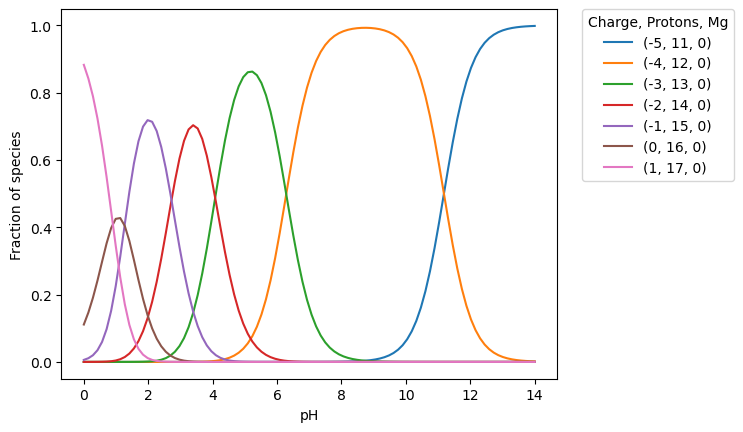

In [8]:
met = tmodel.metabolites.atp_c
ax = thermo_flux.tools.drg_tools.pka_graph(met, pMg = Q_(14,''), ionic_strength = Q_(0.25, 'M'), temperature = Q_(298.15,'K'), accuracy=0, round_dp=False).plot()
ax.set_ylabel('Fraction of species')
ax.set_xlabel('pH')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Charge, Protons, Mg')

Metabolites are assigned a compound from the equilibrator database that can be interacted with using the eQuilibrator api if desired

In [9]:
tmodel.metabolites.biomass_c.charge=0
tmodel.metabolites.biomass_e.charge=0
tmodel.metabolites.biomass_c.formula = 'H74'
tmodel.metabolites.biomass_e.formula = 'H74'

#define biomass formation energy 
tmodel.metabolites.biomass_c.dfG0prime = Q_(-701.767, "kJ/mol") 
tmodel.metabolites.biomass_e.dfG0prime = Q_(-701.767, "kJ/mol") 
tmodel.metabolites.biomass_c.dfG_SE = Q_(0, "kJ/mol") #uncertainty could be added to this value but we fix it for now
tmodel.metabolites.biomass_e.dfG_SE = Q_(0, "kJ/mol")

# a ~2 GB compound cache object is generated when we start modifying thermodynamic parameters
# this can take a while to load initially (~1 min) but then will be faster to access 

### Metabolites with non-decomposable or unknown structures

Some metabolites have non-decomposable or unknown structures e.g. biomass. To ensure correct proton balancing and to use a Gibbs energy dissiaption constraint the number of protons in biomass and the biomass formation energy should be defined. 

## Steps 3-5

### Gibbs energy of formation of biomass

Typically, in thermodynamic FBA the formation energy of biomass is not calculated and it is assumed that the production of biomass is thermodynamically feasible, either by relaxing the second law constraint for production of biomass or allowing a large uncertainty in the formation energy of biomass.  However, if the Gibbs energy dissipation limit is to be estimated or to be used in FBA-type optimizations, then the Gibbs formation energy of the biomass needs to be specified as it contributes to the total Gibbs energy dissipation of a cell (Niebel et al., 2019).  Empirical estimation of biomass formation energy is possible if the elemental composition of biomass is known, and can either be calculated or defined based on literature values (Popovic, 2019; Popovic and Minceva, 2021).   

Formation energy of biomass has can be automatically calcualted from it's elemental composition based on the biomass reaction (if no formula is predefined)

In [10]:
tmodel.reactions.FRUpts2.transported_mets = {tmodel.metabolites.fru_e:-1}
tmodel.reactions.GLCpts.transported_mets = {tmodel.metabolites.glc__D_e :-1}

In [11]:
tmodel.update_thermo_info(fit_unknown_dfG0=True)

Identifying compounds...
[████████████████████████████████████████] 76/76 charge_c                  

Estimating dfG0'...
[████████████████████████████████████████] 78/78 Mg_c                      

Estimating drG0'...
[████████████████████████████████████████] 99/99 EX_charge                                                                                                  



/home/nathan/public_thermo_flux/thermo_flux/core/model.py:183: UserWarning: PIt2r is not balanced and could not be automatically balanced, please check reaction stoichiometry
  drg_transport, dg_protons, dg_electrostatic = drg_tools.calc_drGtransport(rxn,  round_dp = round_dp)


Reactions can now be automatically proton and charge balanced

In [12]:
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False) #for simplicity we're ignoring Mg balance here but it could be enabled 

Transporter variants can be automatically added

In [13]:
# trans_rxns = []
# for rxn in tmodel.reactions:
#     if len(rxn.compartments) > 1:
#         trans_rxns.append(rxn)

# for rxn in trans_rxns:
#     new_reactions = thermo_flux.tools.drg_tools.add_transporter_varaints(rxn,balance_charge=True)
#     if new_reactions is not None:
#         if len(new_reactions) > 0:
#             print(rxn)

#             print(new_reactions)

## save test

In [15]:
from thermo_flux.io import io_thermo_model as io_tm
io_tm.save_thermo_model(tmodel,'dump_1110.yml')
# io_tm.thermo_model_to_dict(tmodel)

# load save test


In [79]:

###import packages
import io
import cobra.io as cio
from collections import OrderedDict
from operator import attrgetter, itemgetter
from typing import TYPE_CHECKING, Dict, List, Sequence, Set, Union
from thermo_flux.core.model import ThermoModel
import yaml

YAML_SPEC = "1.2"

### define thermo objects attributes 
##model attributes 

thermo_model_attributes=["pH", "I", "pMg", "T", "phi", "rmse_inf", "max_drG", "phi_dict"]

##reaction attributes
##make a list of all attributes in reaction class
thermo_reaction_attributes=["_drG0", "_drG0prime", "_drG_SE", "_drGtransport", "_drGtransform", "_transported_h", "_transported_charge", "_transported_mets", "_balanced", "_ignore_snd"]

##metabolite attributes
##make a list of all attributes in metabolite class
thermo_metabolite_attributes=["_dfG0", "_dfG0prime", "_dfG_SE", "_redox", "_biomass", "_ignore_conc"]

 

###first use functions in cobra 

def tf_update_optional(
    cobra_object: "Object",
    new_dict: Dict,
    ordered_keys: Sequence,
) -> None:
    """modified from cobra.io._update_optional
    Update `new_dict` with optional attributes from `cobra_object`.

    Parameters
    ----------
    cobra_object : cobra.Object
        The cobra Object to update optional attributes from.
    new_dict : dict
        The dictionary to update optional attributes for.
    optional_attribute_dict : dict
        The dictionary to use as default value lookup store.
    ordered_keys : list, tuple
        The keys to update values for.

    Raises
    ------
    IndexError
        If key in `ordered_keys` is not found in `optional_attribute_dict`.
    AttributeError
        If key in `ordered_keys` is not found in `cobra_object`.

    """
    for key in ordered_keys:
        value = getattr(cobra_object, key)
        if value is None :
            continue
        new_dict[key] = cio.dict._fix_type(value)



## first i  save model to dict
def thermo_model_to_dict(model: ThermoModel) -> Dict:
    """modified from cobra.io.model_to_dict"""
    #first dump all cobra attributes in a dictionnary
    obj=cio.model_to_dict(model)
    tf_update_optional(model, obj, thermo_model_attributes)

    ##first add model atttributes
    for rxn_dict_i in obj['reactions']: #iterate over all reactions
        for key in thermo_reaction_attributes: #add all rxn attributes
            rxn_dict_i[key]= getattr(model.reactions.get_by_id(rxn_dict_i['id']),key)

    #then metabolites
    for met_dict_i in obj['metabolites']:
        for key in thermo_metabolite_attributes:
            met_dict_i[key]= getattr(model.metabolites.get_by_id(met_dict_i['id']),key)

    return obj
    
#then replicate save function of cobra to dump in yaml
def save_thermo_model(model: ThermoModel, filename: str,**kwargs) -> None:
    """Save a ThermoModel to a YAML file.

    Parameters
    ----------
    model : ThermoModel
        The model to save.
    filename : str
        The filename to save the model to.

    """
    obj = thermo_model_to_dict(model)
    obj["version"] = YAML_SPEC
    with io.open(filename, "w") as file_handle:
            yaml.dump(obj, file_handle,**kwargs )

def drop_metabolite_keys(met: Dict) -> Dict:
    """Drop keys from a metabolite dict that are not in the cobra metabolite class."""
    return {key: val for key, val in met.items() if key not in thermo_metabolite_attributes}

def drop_reaction_keys(rxn: Dict) -> Dict:
    """Drop keys from a reaction dict that are not in the cobra reaction class."""
    return {key: val for key, val in rxn.items() if key not in thermo_reaction_attributes}

def thermo_metabolite_att_from_dict(met,met_dict: Dict) -> ThermoModel:
    cobra_dict=drop_metabolite_keys(met_dict)
    cobra_met= cio.dict._metabolite_from_dict(cobra_dict)
    tmet=thermo_flux.core.metabolite.ThermoMetabolite(cobra_met)
    for key,val in {k:v for k,v in met_dict.items() if k in thermo_metabolite_attributes}.items():
        setattr(tmet,key,val)
    return tmet

def thermo_reaction_from_dict(rxn_dict: Dict,model) -> ThermoModel:
    cobra_dict=drop_reaction_keys(rxn_dict)
    cobra_rxn= cio.dict._reaction_from_dict(cobra_dict,model)
    trxn=thermo_flux.core.reaction.ThermoReaction(cobra_rxn)
    for key,val in {k:v for k,v in rxn_dict.items() if k in thermo_reaction_attributes}.items(): # now add only tf attributes
        setattr(trxn,key,val)
    return trxn
  

def thermo_model_from_dict(obj: Dict) -> ThermoModel:
    """modified from cobra.io.model_from_dict"""
    if "reactions" not in obj:
        raise ValueError("Object has no .reactions attribute. Cannot load.")
    model=cobra.core.model.Model()
    tmodel=ThermoModel(model)
    
    tmodel.add_metabolites(
        [cio.dict.metabolite_from_dict(metabolite) for metabolite in obj["metabolites"]]
    )

    tmodel.add_reactions(
        [thermo_reaction_from_dict(reaction, tmodel) for reaction in obj["reactions"]]
    )
    objective_reactions = [
        rxn for rxn in obj["reactions"] if rxn.get("objective_coefficient", 0) != 0
    ]
    coefficients = {
        model.reactions.get_by_id(rxn["id"]): rxn["objective_coefficient"]
        for rxn in objective_reactions
    }
    cobra.util.solver.set_objective(model, coefficients)
    #finally add model attributes and tf specific aatributes
    for k, v in obj.items():
        if k in {"id", "name", "notes", "compartments", "annotation"} or k in thermo_model_attributes:
            setattr(model, k, v)
    return model

In [17]:

###import packages
import io
import cobra.io as cio
from collections import OrderedDict
from operator import attrgetter, itemgetter
from typing import TYPE_CHECKING, Dict, List, Sequence, Set, Union
from thermo_flux.core.model import ThermoModel
import yaml

YAML_SPEC = "1.2"

### define thermo objects attributes 
##model attributes 

thermo_model_attributes=["pH", "I", "pMg", "T", "phi", "rmse_inf", "max_drG", "phi_dict"]

##reaction attributes
##make a list of all attributes in reaction class
thermo_reaction_attributes=["_drG0", "_drG0prime", "_drG_SE", "_drGtransport", "_drGtransform", "_transported_h", "_transported_charge", "_transported_mets", "_balanced", "_ignore_snd"]

##metabolite attributes
##make a list of all attributes in metabolite class
thermo_metabolite_attributes=["_dfG0", "_dfG0prime", "_dfG_SE", "_redox", "_biomass", "_ignore_conc"]

 

###first use functions in cobra 

def tf_update_optional(
    cobra_object: "Object",
    new_dict: Dict,
    ordered_keys: Sequence,
) -> None:
    """modified from cobra.io._update_optional
    Update `new_dict` with optional attributes from `cobra_object`.

    Parameters
    ----------
    cobra_object : cobra.Object
        The cobra Object to update optional attributes from.
    new_dict : dict
        The dictionary to update optional attributes for.
    optional_attribute_dict : dict
        The dictionary to use as default value lookup store.
    ordered_keys : list, tuple
        The keys to update values for.

    Raises
    ------
    IndexError
        If key in `ordered_keys` is not found in `optional_attribute_dict`.
    AttributeError
        If key in `ordered_keys` is not found in `cobra_object`.

    """
    for key in ordered_keys:
        value = getattr(cobra_object, key)
        if value is None :
            continue
        new_dict[key] = cio.dict._fix_type(value)


### saving the 

## first i do save model to dict
def thermo_model_to_dict(model: ThermoModel) -> Dict:
    """modified from cobra.io.model_to_dict"""
    #first dump all cobra attributes in a dictionnary
    obj=cio.model_to_dict(model)
    tf_update_optional(model, obj, thermo_model_attributes)

    ##first add model atttributes
    for rxn_dict_i in obj['reactions']: #iterate over all reactions
        for key in thermo_reaction_attributes: #add all rxn attributes
            rxn_dict_i[key]= getattr(model.reactions.get_by_id(rxn_dict_i['id']),key)

    #then metabolites
    for met_dict_i in obj['metabolites']:
        for key in thermo_metabolite_attributes:
            met_dict_i[key]= getattr(model.metabolites.get_by_id(met_dict_i['id']),key)

    return obj
    
#then replicate save function of cobra to dump in yaml
def save_thermo_model(model: ThermoModel, filename: str,**kwargs) -> None:
    """Save a ThermoModel to a YAML file.

    Parameters
    ----------
    model : ThermoModel
        The model to save.
    filename : str
        The filename to save the model to.

    """
    obj = thermo_model_to_dict(model)
    obj["version"] = YAML_SPEC
    with io.open(filename, "w") as file_handle:
            yaml.dump(obj, file_handle,**kwargs )

def drop_metabolite_keys(met: Dict) -> Dict:
    """Drop keys from a metabolite dict that are not in the cobra metabolite class."""
    return {key: val for key, val in met.items() if key not in thermo_metabolite_attributes}

def drop_reaction_keys(rxn: Dict) -> Dict:
    """Drop keys from a reaction dict that are not in the cobra reaction class."""
    return {key: val for key, val in rxn.items() if key not in thermo_reaction_attributes}

def thermo_metabolite_att_from_dict(cobra_met,met_dict: Dict) -> ThermoModel:
    tmet=thermo_flux.core.metabolite.ThermoMetabolite(cobra_met)
    for key,val in {k:v for k,v in met_dict.items() if k in thermo_metabolite_attributes}.items():
        setattr(tmet,key,val)
    

# def thermo_reaction_att_from_dict(cobra_rxn,rxn_dict: Dict,model) -> ThermoModel:
#     for key,val in {k:v for k,v in rxn_dict.items() if k in thermo_reaction_attributes}.items(): # now add only tf attributes
#         setattr(cobra_rxn,key,val)
    
  

def thermo_model_from_dict(obj: Dict) -> ThermoModel:
    """modified from cobra.io.model_from_dict"""
    if "reactions" not in obj:
        raise ValueError("Object has no .reactions attribute. Cannot load.")
    model=cobra.core.model.Model()
    ##metabolites : add them to cobra model, then add tf attributes 
    model.add_metabolites(
    [cio.dict._metabolite_from_dict(metabolite) for metabolite in obj["metabolites"]]
)
    for metabolite_dict in obj["metabolites"]:
        cobra_met=model.metabolites.get_by_id(metabolite_dict['id'])
        thermo_metabolite_att_from_dict(cobra_met,metabolite_dict)
    ## reactions : first add cobra reactions, then add tf attributes
    model.add_reactions(
        [cio.dict._reaction_from_dict(reaction, model) for reaction in obj["reactions"]]
    )
    # model.add_reactions(
    #     [thermo_reaction_from_dict(reaction, model) for reaction in obj["reactions"]]
    # )
    # for reaction_dict in obj["reactions"]:
    #     cobra_rxn=model.reactions.get_by_id(reaction_dict['id'])
    #     thermo_reaction_att_from_dict(cobra_rxn,reaction_dict,model)
    tmodel=ThermoModel(model)
    objective_reactions = [
        rxn for rxn in obj["reactions"] if rxn.get("objective_coefficient", 0) != 0
    ]
    coefficients = {
        model.reactions.get_by_id(rxn["id"]): rxn["objective_coefficient"]
        for rxn in objective_reactions
    }
    cobra.util.solver.set_objective(model, coefficients)
    #finally add model attributes and tf specific aatributes
    for k, v in obj.items():
        if k in {"id", "name", "notes", "compartments", "annotation"} or k in thermo_model_attributes:
            setattr(model, k, v)
    return model

In [48]:
def thermo_reaction_from_dict(rxn_dict: Dict,model) -> ThermoModel:
    cobra_dict=drop_reaction_keys(rxn_dict)
    cobra_rxn= cio.dict._reaction_from_dict(cobra_dict,model)
    trxn=thermo_flux.core.reaction.ThermoReaction(cobra_rxn)
    for key,val in {k:v for k,v in rxn_dict.items() if k in thermo_reaction_attributes}.items(): # now add only tf attributes
        setattr(trxn,key,val)
    return trxn
  

11/10  i can save a thermo modle in a dict but also a json file. the dict has all the attributes for metabolites, reaction and model

In [ ]:
obj=thermo_model_to_dict(tmodel)

In [112]:
from thermo_flux.core.metabolite import ThermoMetabolite

### first i load a cobra model 
emodel=cobra.core.model.Model()

##metabolites : add them to cobra model, then add tf attributes 
emodel.add_metabolites(
[ThermoMetabolite(cio.dict._metabolite_from_dict(metabolite)) for metabolite in obj["metabolites"]]
)
for metabolite_dict in obj["metabolites"]:
    cobra_met=emodel.metabolites.get_by_id(metabolite_dict['id'])
    thermo_metabolite_att_from_dict(cobra_met,metabolite_dict)

### then i need to connect a component contribution object to the model, so that we can fetch compounds for metabolites when adding rxns
from equilibrator_api import ComponentContribution

from equilibrator_assets.local_compound_cache import LocalCompoundCache
#first define a cache, with a given file path if it exists
lc = LocalCompoundCache()

cache_name = str(model.id)+'_compound.sqlite'
from pathlib import Path
#try and load a local cache with the model id
if Path(cache_name).is_file(): 
    lc.load_cache(cache_name)
    emodel._lc = lc
else: #otherwise generate a new local cache 
    lc.generate_local_cache_from_default_zenodo(cache_name, force_write=True)
    lc.load_cache(cache_name)
    emodel._lc=lc
emodel.cc= ComponentContribution(rmse_inf=obj['rmse_inf'], ccache=emodel._lc.ccache)

# ### then i  need to add reactions to the model
for rxn_dict in obj['reactions']:
    add_thermo_reaction_from_dict(rxn_dict,emodel)


cxcalc is not installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Install cxcalc and obtain a ChemAxon license to enable compound creation.
Loading compounds from e_coli_core_compound.sqlite
Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K)
Compound(id=6, inchi_key=ZKHQWZAMYRWXGA-KQYNXXCUSA-J)
Compound(id=125172, inchi_key=BGWGXPAPYGQALX-VRPWFDPXSA-N
)
Compound(id=396, inchi_key=RNBGYGVWRKECFJ-VRPWFDPXSA-J)
Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N)
Compound(id=23, inchi_key=ZSLZBFCDCINBPY-ZSJPKINUSA-J)
Compound(id=15, inchi_key=RGJOEKWQDUBAIZ-IBOSZNHHSA-J)
Compound(id=41, inchi_key=BDAGIHXWWSANSR-UHFFFAOYSA-M)
Compound(id=25, inchi_key=LCTONWCANYUPML-UHFFFAOYSA-M)
Compound(id=125172, inchi_key=BGWGXPAPYGQALX-VRPWFDPXSA-N
)
Compound(id=152, inchi_key=NBSCHQHZLSJFNQ-GASJEMHNSA-L)
Compound(id=248, inchi_key=LJQLQCAXBUHEAZ-UWTATZPHSA-J)
Compound(id=118, inchi_key=OSJPPGNTCRNQQC-UWTATZPHSA-K)
Compound(id=10, inchi_key=XTWYTF

In [115]:
tmodel=ThermoModel(emodel)
tmodel=ThermoModel(model)
objective_reactions = [
    rxn for rxn in obj["reactions"] if rxn.get("objective_coefficient", 0) != 0
]
coefficients = {
    model.reactions.get_by_id(rxn["id"]): rxn["objective_coefficient"]
    for rxn in objective_reactions
}
cobra.util.solver.set_objective(model, coefficients)
#finally add model attributes and tf specific aatributes
for k, v in obj.items():
    if k in {"id", "name", "notes", "compartments", "annotation"} or k in thermo_model_attributes and k !='phi_dict':
        setattr(tmodel, k, v)

tmodel


added reaction:  biomass_ce:  <=> biomass_e
added reaction:  biomass_EX: biomass_e <=> biomass_c
Initializing component contribution object...
cxcalc is not installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Install cxcalc and obtain a ChemAxon license to enable compound creation.
Loading compounds from e_coli_core_compound.sqlite
added reaction:  biomass_ce: biomass_c <=> biomass_e
added reaction:  biomass_EX: biomass_e <=> 
added reaction:  charge_ce: charge_e <=> charge_c
added reaction:  EX_charge: charge_e <=> 


Name,e_coli_core
Memory address,740bc4fa4c70
Number of metabolites,76
Number of reactions,99
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [111]:
import thermo_flux.tools


rxn_dict=obj['reactions'][0]
emodel.remove_reactions(emodel.reactions)
cobra_dict=drop_reaction_keys(rxn_dict)
cobra_rxn= cio.dict._reaction_from_dict(cobra_dict,model)


emodel.add_reactions([cobra_rxn])
for met, stoich in emodel.reactions.get_by_id(rxn_dict['id']).metabolites.items(): #initialisation will be slightly longer but it avoids to compute it each time net_elements is called
    met.compound
trxn=thermo_flux.core.reaction.ThermoReaction(emodel.reactions.get_by_id(rxn_dict['id']))
for key,val in {k:v for k,v in rxn_dict.items() if k in thermo_reaction_attributes}.items(): # now add only tf attributes
    # print(key,val)
    setattr(trxn,key,val)
emodel.remove_reactions([cobra_rxn])
emodel.add_reactions([trxn])

In [106]:
def add_thermo_reaction_from_dict(rxn_dict: Dict,model) -> ThermoModel:
    """here i first make a cobra reaction from the dict, then add it to the model. As the model already has a cc attribute and the reaciton is linked to it
    I can turn the reaction in a thermoReaction. Finally i replace the cobra rxn by the thermoreaction"""
    cobra_dict=drop_reaction_keys(rxn_dict)
    cobra_rxn= cio.dict._reaction_from_dict(cobra_dict,model)
    emodel.add_reactions([cobra_rxn])
    ###initialise the metabolites compound attribute by activate the compound setter
    for met, stoich in emodel.reactions.get_by_id(rxn_dict['id']).metabolites.items(): #initialisation will be slightly longer but it avoids to compute it each time net_elements is called
        print(met.compound)
    trxn=thermo_flux.core.reaction.ThermoReaction(emodel.reactions.get_by_id(rxn_dict['id']))
    for key,val in {k:v for k,v in rxn_dict.items() if k in thermo_reaction_attributes}.items(): # now add only tf attributes
        setattr(trxn,key,val)
    emodel.remove_reactions([cobra_rxn])
    emodel.add_reactions([trxn])

In [104]:
add_thermo_reaction_from_dict(obj['reactions'][1],emodel)

Compound(id=23, inchi_key=ZSLZBFCDCINBPY-ZSJPKINUSA-J)
Compound(id=15, inchi_key=RGJOEKWQDUBAIZ-IBOSZNHHSA-J)
Compound(id=41, inchi_key=BDAGIHXWWSANSR-UHFFFAOYSA-M)
Compound(id=25, inchi_key=LCTONWCANYUPML-UHFFFAOYSA-M)


In [42]:
[met for met in emodel.metabolites if met.model==None]

[]

## end test

The model can still be optimized using standard COBRA functions and FBA. We can test there are no issues with the stoichiometry by running an standard FBA optimization. 

In [21]:
emodel.objective = emodel.reactions.biomass_EX #make sure the objective is the biomass export reaction 
sol = emodel.optimize()
emodel.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


## Step 6: Formulation of the combined stoichiometic thermodynamic solution space
Now the model is fully parameterized we can run FBA style optimizations with thermodynamic constraints. 

Metabolite concnetration bounds can be defined

In [65]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = 12, error_type = 'covariance')#, split_v = True)

# this has now created a Gurobi model object accessible via tmodel.m
print(tmodel.m)

# The gurobi model object can be interacted with directly via the gurobypy api. Extensive documentation can be found here: https://www.gurobi.com/documentation/10/refman/py_model.html

#set a 30s time limit for the solver
tmodel.m.Params.TimeLimit = 30

# start the optimization 
tmodel.m.optimize()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
<gurobi.Model MIP instance minlp: 726 constrs, 771 vars, Parameter changes: TimeLimit=10.0, Username=(user-defined), NonConvex=2>
Set parameter TimeLimit to value 30
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 826 rows, 849 columns and 5290 nonzeros
Model fingerprint: 0xfe148378
Model has 22 quadratic constraints
Model has 1 general constraint
Variable types: 750 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-02, 1e+04]
Presolve removed 403 rows and 427 columns
Presolve time: 0.01s
Presolved: 484 r

In [ ]:
# All the TFBA variables are now stored in the tmodel.mvars dictionary
print(tmodel.mvars.keys())
# these are gurobi mvar objects and can be modified (e.g. lower and upper bounds start values etc.) using the.gurobipy api

# otherwise a solution dataframe is generated by tmodel.solution()
sol = tmodel.solution()

#create a list of internal and exchange reactions based on cobra boundary function 
int_rxns = [rxn.id for rxn  in tmodel.reactions if rxn not in tmodel.boundary]
ex_rxns = [rxn.id for rxn  in tmodel.reactions if rxn  in tmodel.boundary]

#index the solution dataframe using these lists and sum the gibbs energy dissipation 
print('Gdiss internal: ', sol.loc[int_rxns]['Gdiss'].sum())
print('Gdiss exchange: ', sol.loc[ex_rxns]['Gdiss'].sum())

display(sol)


Variability analysis on the drG values can be performed to identify reactions that are reversible. This analysis takes into account the metabolites concentration bounds and the uncertainty in the drG0 values. 

In [ ]:
bounds = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95, condition_index = 0)

### Optimization results 

View a the optimisation results and check the gibbs energy balance was met correctly.



In [67]:
# All the TFBA variables are now stored in the tmodel.mvars dictionary
print(tmodel.mvars.keys())
# these are gurobi mvar objects and can be modified (e.g. lower and upper bounds start values etc.) using the.gurobipy api

# otherwise a solution dataframe is generated by tmodel.solution()
sol = tmodel.solution()

#create a list of internal and exchange reactions based on cobra boundary function 
int_rxns = [rxn.id for rxn  in tmodel.reactions if rxn not in tmodel.boundary]
ex_rxns = [rxn.id for rxn  in tmodel.reactions if rxn  in tmodel.boundary]

#index the solution dataframe using these lists ans sum the gibbs energy dissipation 
print('Gdiss internal: ', sol.loc[int_rxns]['Gdiss'].sum())
print('Gdiss exchange: ', sol.loc[ex_rxns]['Gdiss'].sum())

#this value should also match the g_2 variable if the Gdiss limit option was used in the TFBA formulation
print('Gdiss exchange TFBA: ', tmodel.mvars['g_2'].x)


dict_keys(['b', 'v', 'drGp', 'drGn', 'ln_conc', 'drG', 'drG_error', 'drG_conc', 'qm', 'mnorm', 'Gdiss', 'g_2'])
Gdiss internal:  -3637.7998730183426
Gdiss exchange:  3637.7998029011487
Gdiss exchange TFBA:  [3637.79980295]


The method ThermoModel.solution() returns the dataframe of the main Gurobi variables and their values

In [68]:
tmodel.solution().loc[tmodel.solution().index.str.contains('ATP')]


,v,drG,Gdiss,drG0_prime,drG_error,drG_conc,b,condition
reaction,,,,,,,,
ATPM,8.390077,-71.312476,-598.317153,-30.988323,-0.048787,-40.275369,1.0,0
ATPS4r,30.885247,-0.500004,-15.442758,-40.824161,0.048787,40.275369,1.0,0


### Scanning a variable bound 

We're often interested in the effect of the gibbs energy dissipation limit as we increase the glucose uptake rate. We can take advantage of the Gurobi multi scenario feature to scan through a range of values for a particular variable and solve the optimisations in an efficeint way. 

In [69]:
# First we fix the drG_errors to the values from our initial optimization 
# This is optional but will:
# i: help the solver converge faster
# ii: ensure we have a consistent set of drG0prime values for each glucose uptake condition (this is analgous to running the regressions on literature data and using this to fix the drGerror values)) 

# the qm vector defined the errors in the covariance matrix 
qm = tmodel.mvars['qm'].x #get the qm values from the initial solution
#fix the values in the model 
tmodel.mvars['qm'].lb = qm 
tmodel.mvars['qm'].ub = qm
tmodel.m.update() #update the model with the new bounds

#define a range of glucose uptake rate values to scan through 
GUR_range =  np.linspace(-1,-15, 15) 
print(GUR_range)

#set up a multiscenario optimization to scan over the glucose upake rate
thermo_flux.solver.gurobi.variable_scan(tmodel, GUR_range, var = tmodel.mvars['v'][0][tmodel.reactions.index(tmodel.reactions.EX_glc__D_e)]) # here we get the index for the glucose uptake reaction and use this to index the v variable in the gurobi model

tmodel.m.optimize()

[ -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13. -14.
 -15.]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 826 rows, 849 columns and 5290 nonzeros
Model fingerprint: 0x9d7c6ec7
Model has 22 quadratic constraints
Model has 1 general constraint
Variable types: 750 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-04, 1e+06]
  RHS range        [3e-02, 1e+04]

Solving a multi-scenario model with 15 scenarios...


MIP start from previous solve produced solution with objective 0.0472562 (0.03s)
MIP start from previous solve produced solution with objective 0.229667 (0.03s)
MIP start from previou

In [70]:
#get the fluxes from the multiscenario optimization
fluxes = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'v') 
fluxes= pd.DataFrame(fluxes[0].T, index = [rxn.id for rxn in tmodel.reactions])
display(fluxes)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PFK,0.951997,1.753217,2.470779,3.188342,3.905905,4.623467,5.293003,5.951875,6.610747,7.330405,8.219059,9.107714e+00,9.996368e+00,10.885022,11.810783
PFL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997929,4.770312,8.542696e+00,1.231508e+01,16.087463,17.882170
PGI,0.990107,1.649423,2.056218,2.463014,2.869809,3.276604,3.435512,3.539379,3.643245,3.917054,4.663342,5.409629e+00,6.155917e+00,6.902204,7.733042
PGK,-1.871714,-3.519895,-5.085346,-6.650797,-8.216248,-9.781699,-11.361264,-12.943962,-14.526661,-16.177576,-18.018147,-1.985872e+01,-2.169929e+01,-23.539861,-25.433562
PGL,0.000000,0.321825,0.896286,1.470746,2.045207,2.619668,3.449673,4.336420,5.223167,5.940886,6.188674,6.436461e+00,6.684249e+00,6.932036,7.097247
ACALD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.531809e-09,0.000000e+00,0.000000,0.000000
AKGt2r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.138075e-09,0.000000e+00,0.000000,0.000000
PGM,-1.799519,-3.310078,-4.738742,-6.167406,-7.596070,-9.024734,-10.523392,-12.037592,-13.551792,-15.140890,-16.938222,-1.873555e+01,-2.053289e+01,-22.330218,-24.195090
PIt2r,0.177529,0.515943,0.852305,1.188668,1.525031,1.861393,2.060345,2.228787,2.397228,2.549237,2.655563,2.761889e+00,2.868214e+00,2.974540,3.045432
ALCD2x,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000


### Plot the fluxes

Create a function to handle plotting of mutiple exchange fluxes and overlaying individual data points. 

In [71]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import ceil


def exchange_plot(flux_list, rxn_list = ['biomass_EX', 'EX_co2_e', 'EX_acald_e','EX_ac_e','EX_for_e','EX_etoh_e','EX_pyr_e','EX_o2_e'],
                  x_axis_data= 'EX_glc__D_e',
                  titles = ['Biomass production', 'CO2 production', 'Acetaldehyde production', 'Acetate production', 'Formate production', 'EtOH production','Pyruvate production','Oxygen Uptake'],
                  y_upper = [1.5, 30,20.4,14.4,17.7,14.2,14.4, 15],
                  overlay=True,
                  legend_labels = ['WT'],
                  flux_data = None,
                  save = False):
    
    cols = 4
    rows = ceil(len(rxn_list)/cols)
 
    #overlay all plot on one graph
    if overlay:
        #make a subplot figure
        fig, axes = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True,figsize=(10,8),dpi= 300)

    titles = ['Biomass production', 'CO2 production', 'Acetaldehyde production', 'Acetate production', 'Formate production', 'EtOH production','Pyruvate production','Oxygen Uptake']


    for ii, fluxes in enumerate(flux_list):

        if not overlay: #make a new subplot for each set of fluxes 
            fig, axes = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True,figsize=(10,8),dpi= 300)

        #loop through the figure axis and add data to each plot
        for i, ax in enumerate(fig.axes):
                
            data = abs(fluxes.loc[rxn_list[i]]).sort_index()
            data.index = abs(fluxes.loc[x_axis_data])
            if 0 in data:
                data = data.drop(0)


            #if the fluxes are <1 then multiply by -1
            if data.max() < 0:
                data = data*-1

            data.plot(style='o-',linewidth=3,markersize=3,xlabel = 'GUR (mmol gCDW$^{-1}$ h$^{-1}$ )', ylabel = 'Flux',  title = titles[i] , ax=ax,xlim=[0,15],ylim =0, alpha = 0.8) 

            if flux_data is not None:
                #add the experimental data to the plot
                if rxn_list[i] in flux_data.columns.to_list():
                    exp_data = flux_data[['EX_glc__D_e', rxn_list[i]]]
                    if legend_labels[ii] in exp_data.index.to_list():
                        exp_data =  exp_data.loc[legend_labels[ii]]

                        ax.scatter(marker = 'x',s = 50, color=ax.lines[-1].get_color() ,x=exp_data.loc['EX_glc__D_e'], y=exp_data.loc[rxn_list[i]])

        #add the legend - have to do this manually to get the lines and data to match... 
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        handles= []
        for i, ko in enumerate(legend_labels):
            handle = mlines.Line2D([], [], color=colors[i], marker='o',
                                    markersize=5, label=ko)

            handles.append(handle)

        for i, ax in enumerate(fig.axes):
        
            ax.legend(handles = handles)

#         if save:
# #             plt.savefig(legend_labels[ii]+'_.png')

        #hide the plot
        if not overlay:
            plt.close(fig)

    return fig

Import data from knock out experiments and overlay this on the simulated fluxes

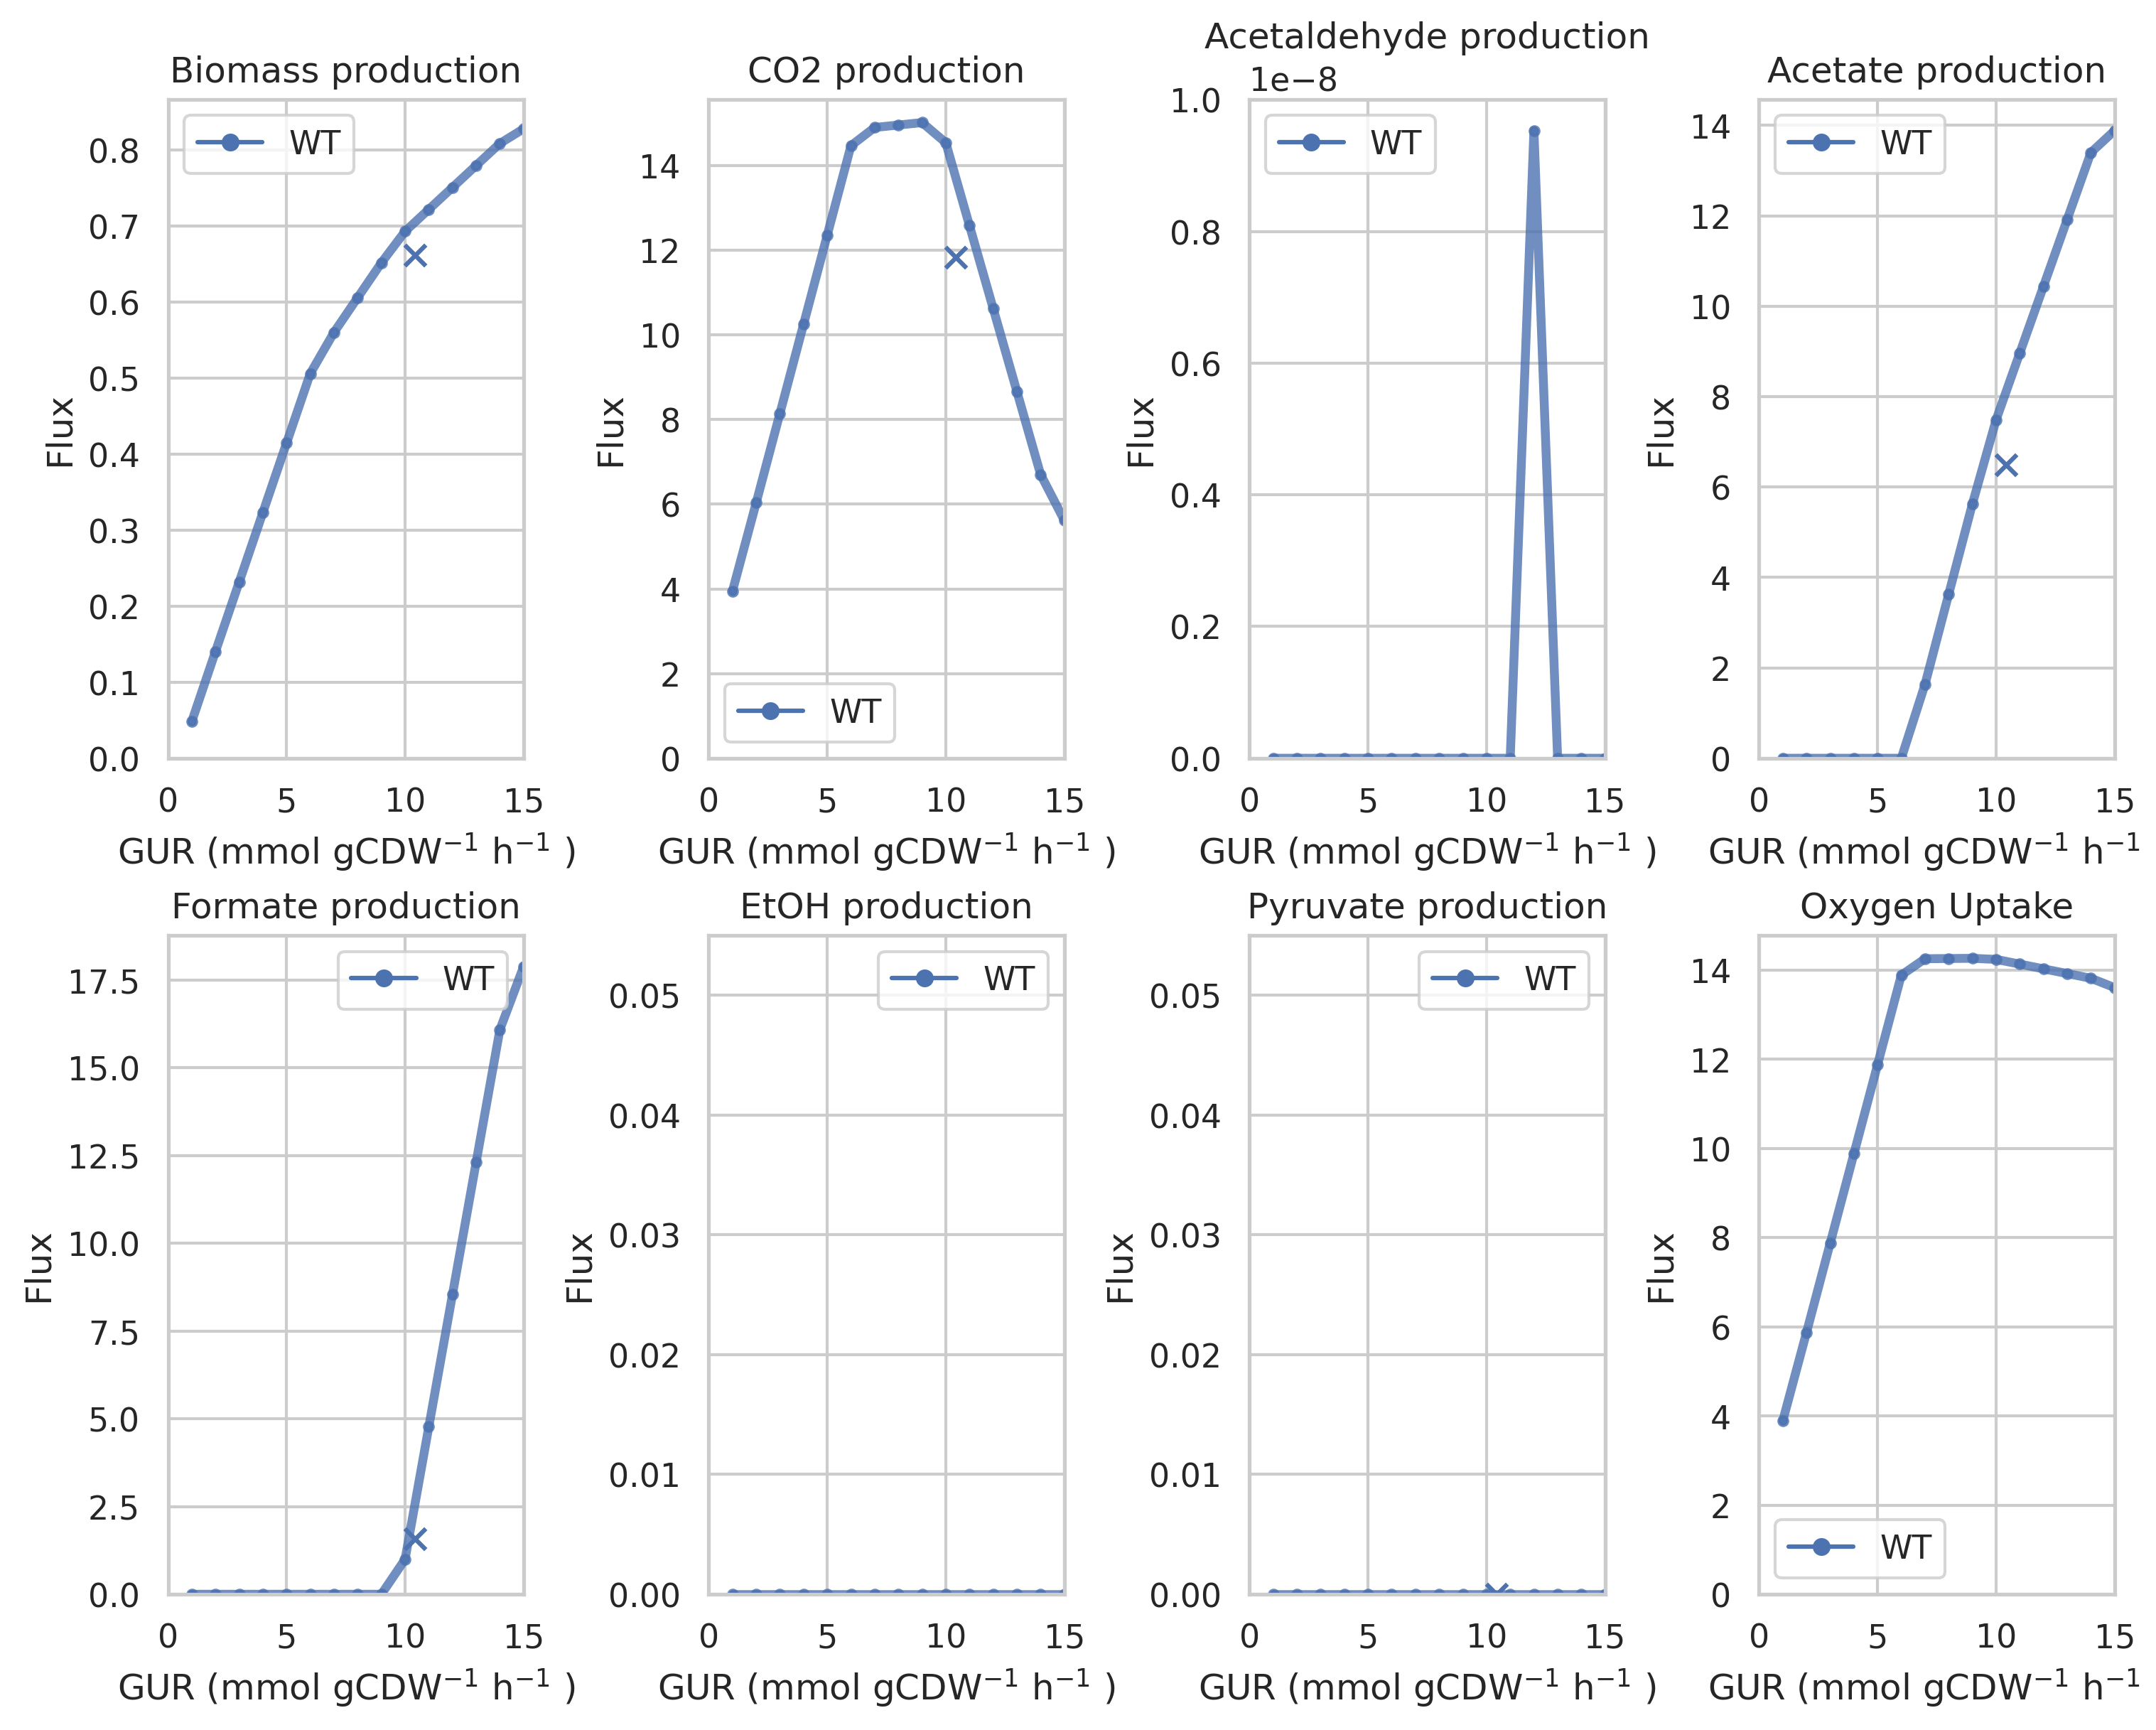

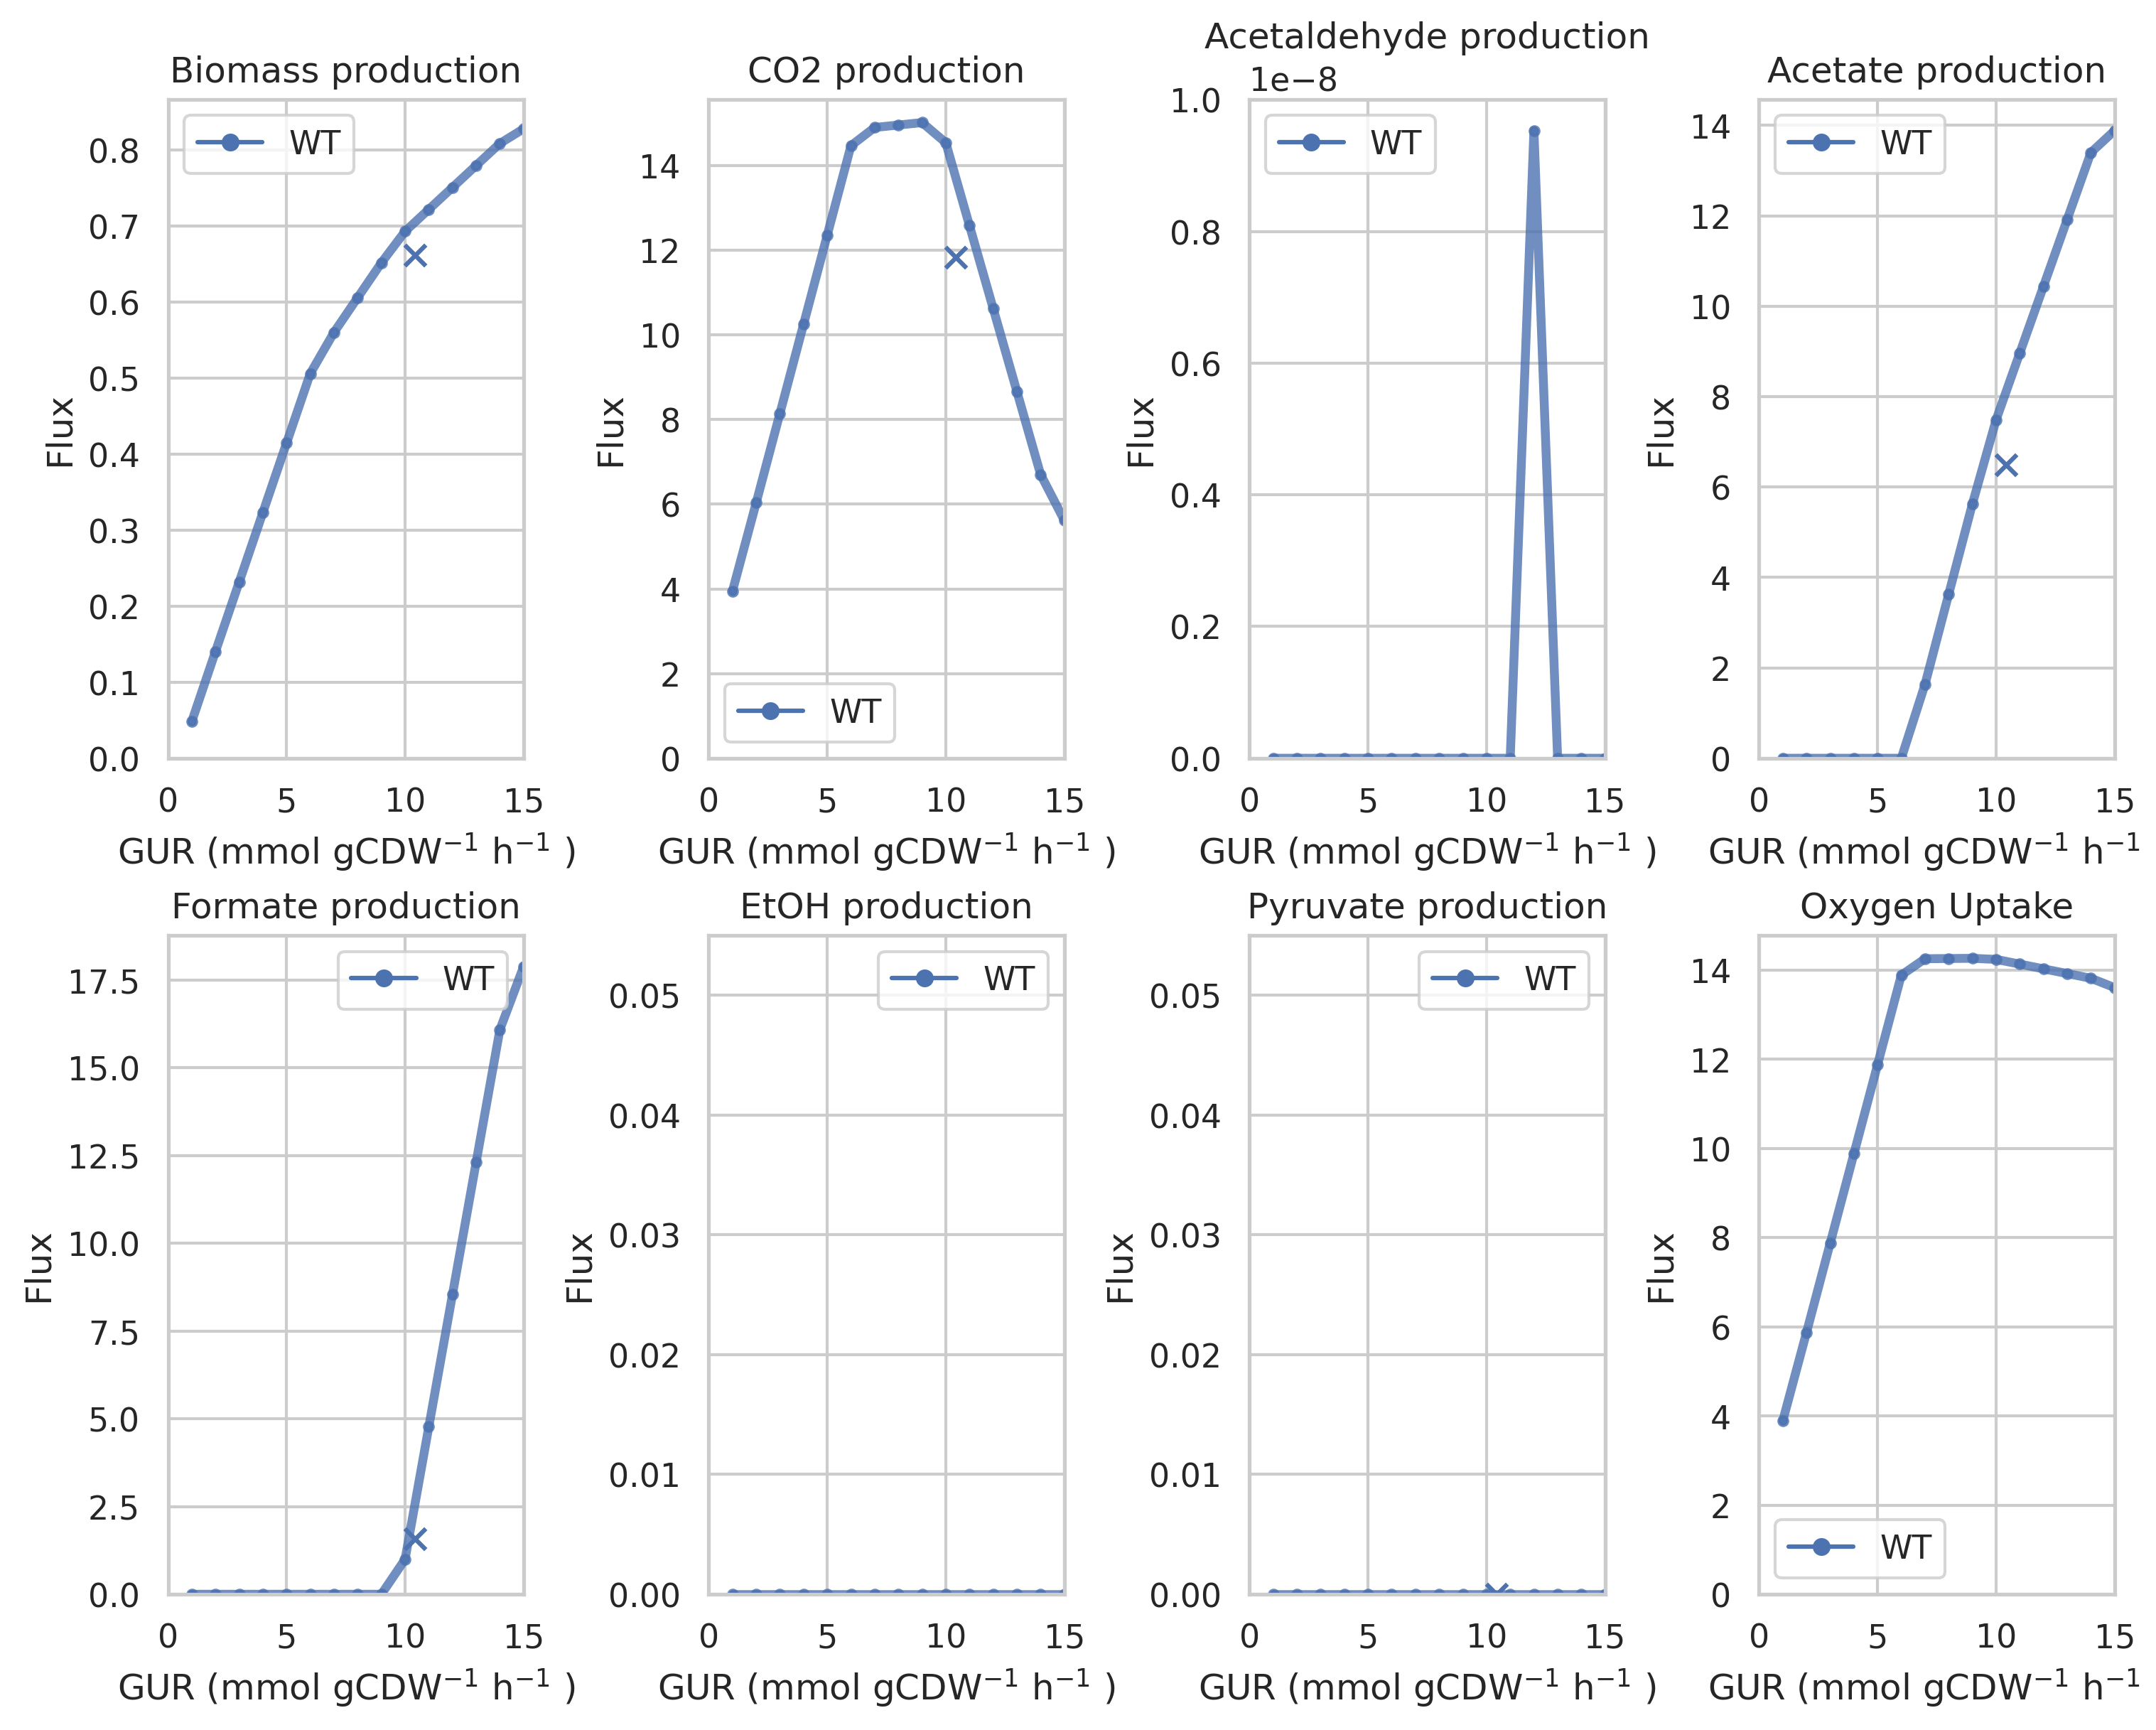

In [72]:
#### specify the path of the flux data 
#  read the flux data from Vitors knockouts
flux_data= pd.read_csv(f'{INPUT_FOLDER}/flux_data_vitor.csv')
flux_data.set_index(['cond','rxn'], inplace=True)
flux_data = flux_data.reset_index().pivot(index='cond',columns='rxn', values='mean')
flux_data['EX_glc__D_e'] = flux_data['EX_glc__D_e']*-1 #swap the sign on the glucose uptake for plotting 
flux_data = flux_data.fillna(0)

# plot the data 
exchange_plot([fluxes], flux_data=flux_data)

### Comparing to published experimental data

Next we can compare to the published experimental data used in the Neibel et.al. 2019 paper to run regressions on the genome scale E. coli model. 

In [73]:
#import experimental data from Neibel et. al. 2019
reg_data = hl.excel_to_df(f'{INPUT_FOLDER}/data_allC.xlsx')


reg_data['dvmeas'] = reg_data['dvmeas'].reset_index()
reg_data['dvmeas'].columns = ['cond','rxn','mean_sd','Value']
reg_data['dvmeas'] = reg_data['dvmeas'].replace({'biomass':'biomass_EX'})
reg_data['dvmeas'] = reg_data['dvmeas'].pivot(index=['cond', 'rxn'], columns='mean_sd', values='Value').rename_axis(None, axis=1)
reg_data['dvmeas'] = reg_data['dvmeas'].fillna(0)

#rename reactions to match this textbook model example 
reg_data['dvmeas'] = reg_data['dvmeas'].rename({'EX_ac':'EX_ac_e',
                          'EX_co2':'EX_co2_e',
                          'EX_glc':'EX_glc__D_e',
                          'EX_o2':'EX_o2_e',
                          'EX_pyr':'EX_pyr_e'
                          }) 

#Dataframe of experimental fluxes 
reg_all = reg_data['dvmeas'].reset_index()

reg_all = reg_all.pivot(index='cond',columns='rxn', values='mean')




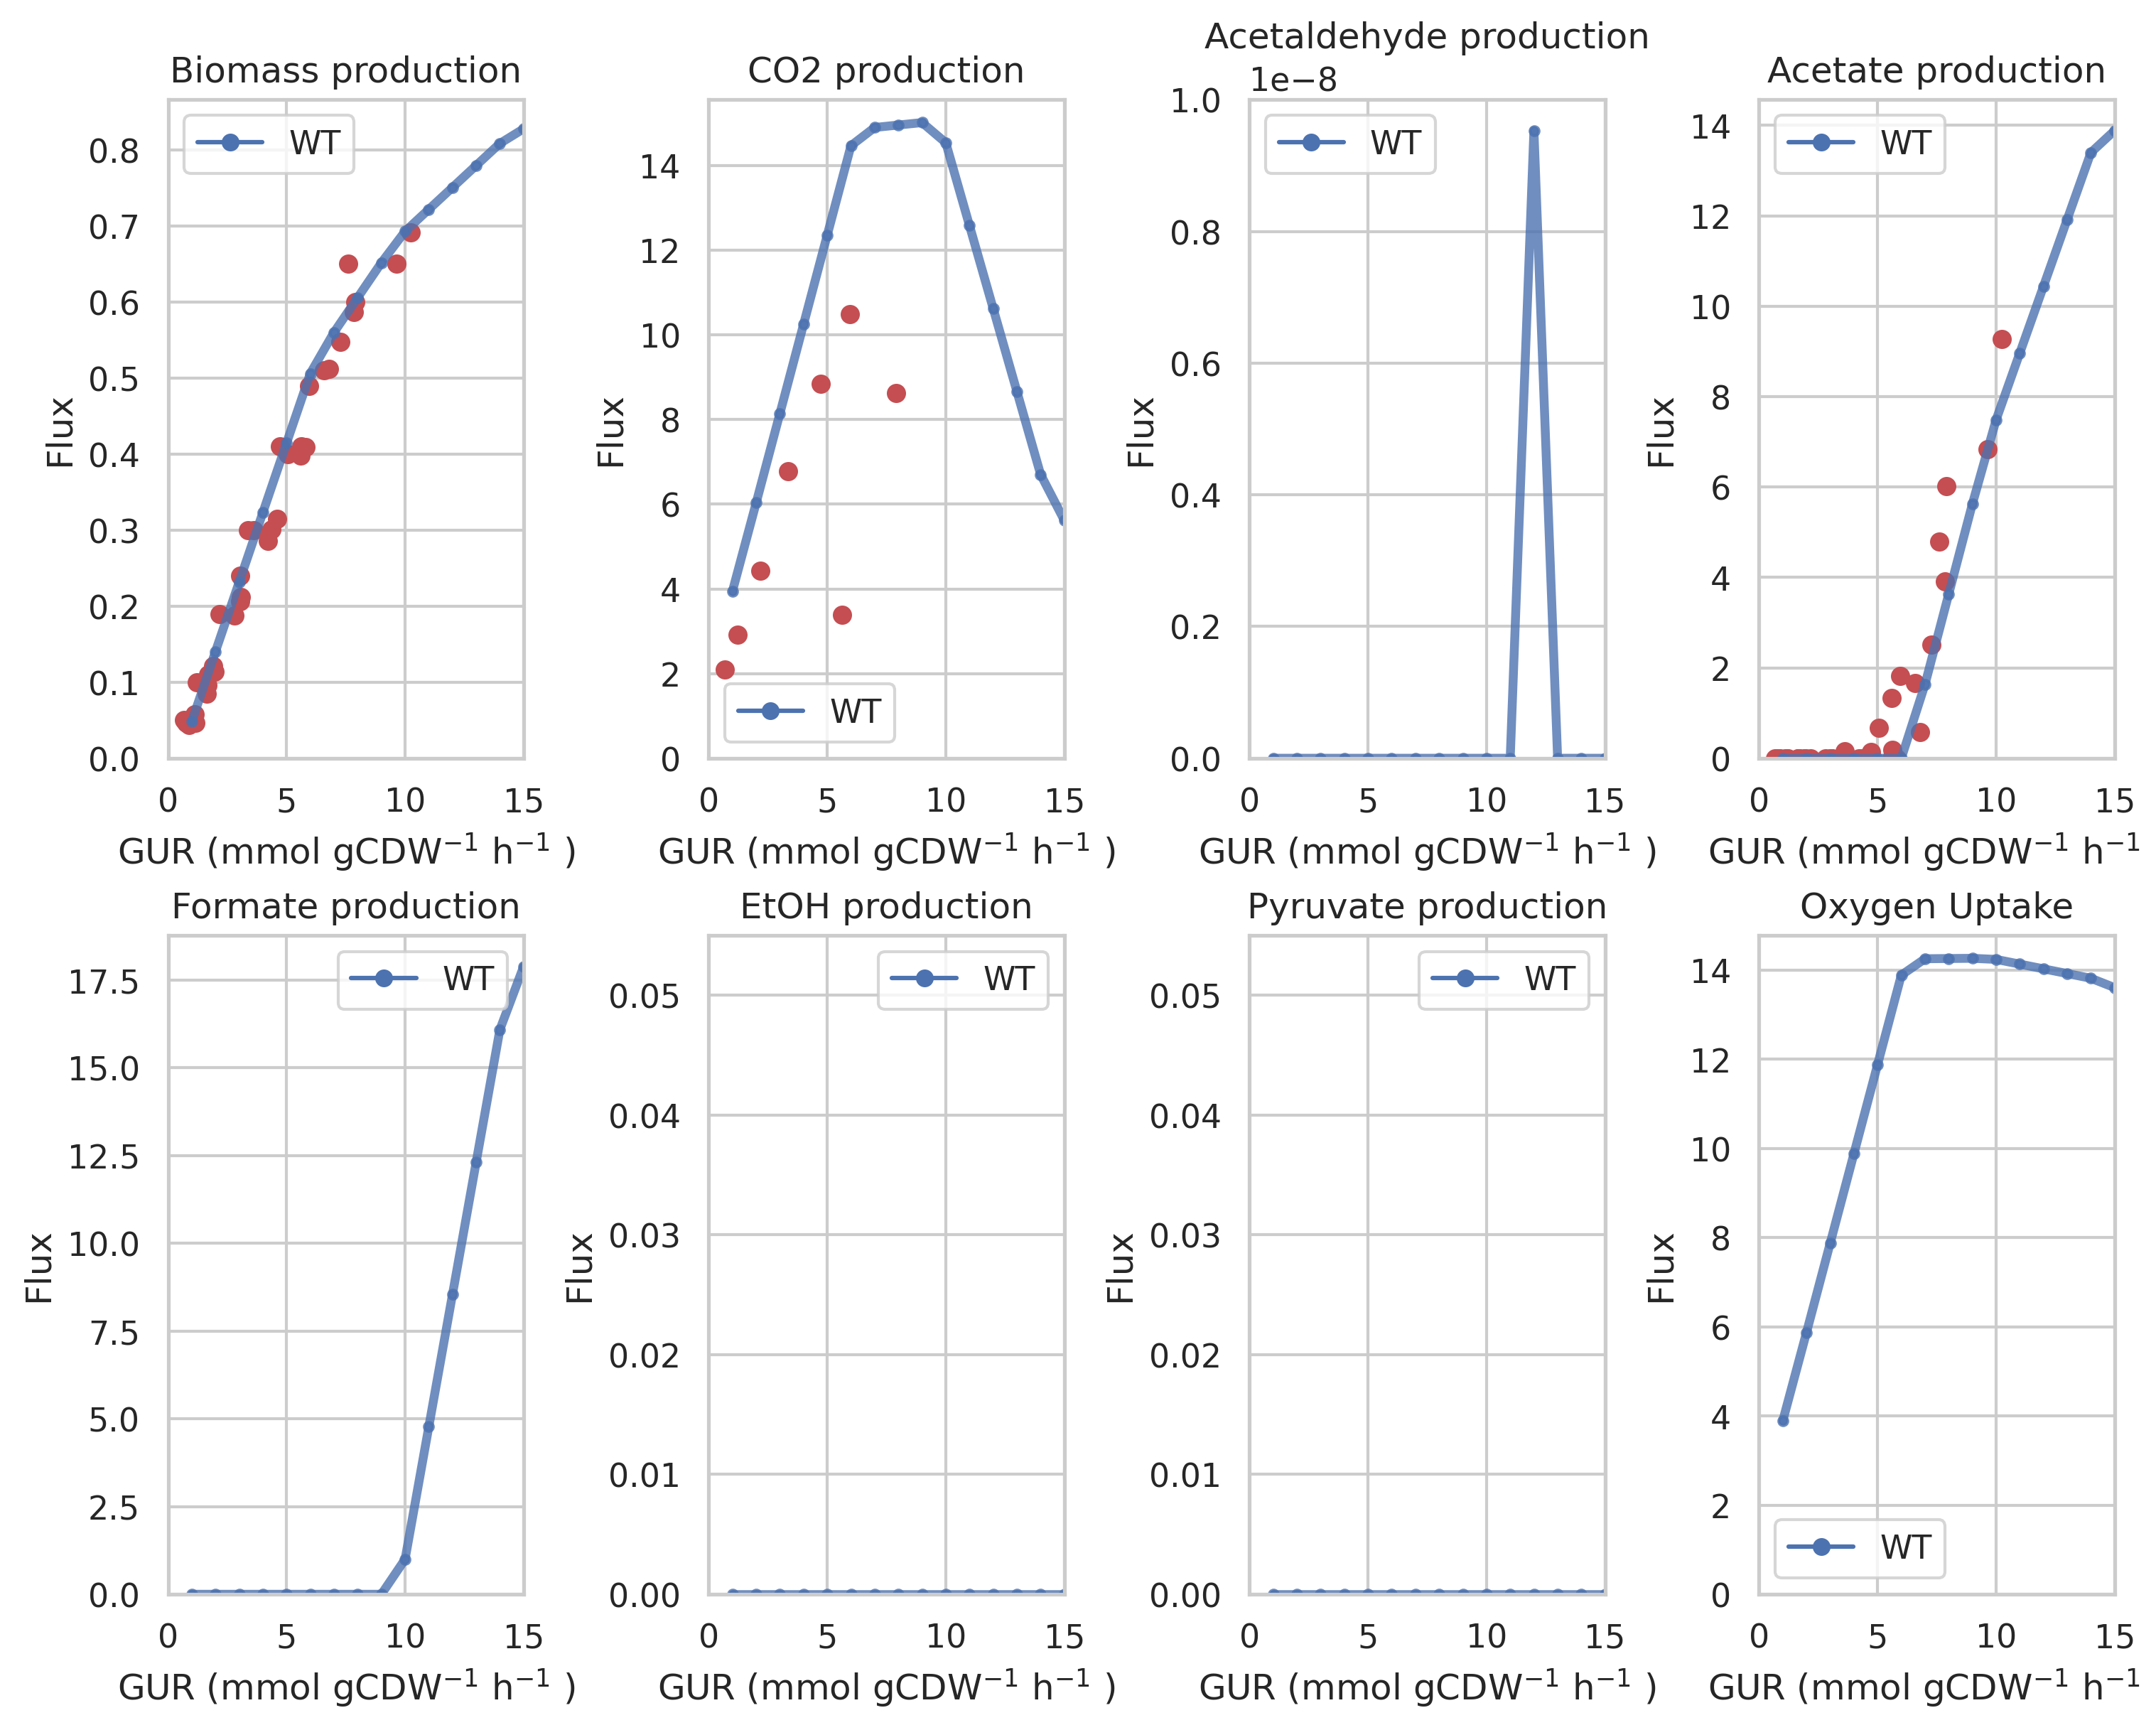

In [74]:
## make a new plot with all the data 

fig = exchange_plot([fluxes])

rxn_list = ['biomass_EX', 'EX_co2_e', 'EX_acald_e','EX_ac_e','EX_for_e','EX_etoh_e','EX_pyr_e','EX_lac__D_e']
for i, ax in enumerate(fig.axes):

    #add the experimental data to the plot
    if rxn_list[i] in reg_all.columns.to_list():
        exp_data = reg_all[['EX_glc__D_e', rxn_list[i]]]
        

        ax.scatter(marker = 'o',s = 30, color='r' ,x=abs(reg_all['EX_glc__D_e']), y=abs(reg_all[rxn_list[i]]))





Analyse the part of exchange reactions in the total gibbs energy dissipation rate

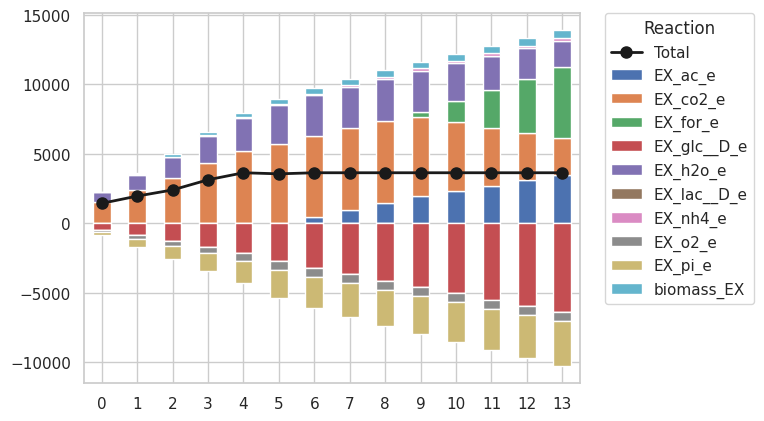

In [75]:
Gdiss = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'Gdiss') 
Gdiss= pd.DataFrame(Gdiss[0].T, index = [rxn.id for rxn in tmodel.boundary])

#drop column 14
Gdiss = Gdiss.drop(14, axis=1)

#round values to 5 dp
Gdiss = Gdiss.round(5)

#drop rows from gdiss with all zeros
Gdiss = Gdiss.loc[(Gdiss!=0).any(axis=1)]

#make a stacked bar graph for each condition in Gdiss (columns)
import matplotlib.pyplot as plt

# Create a stacked line graph
Gdiss.T.plot(kind='bar', stacked=True)

#overlay plot with sum of column
Gdiss.sum().plot(secondary_y=False, color='k', marker='o', linewidth=2, markersize=8, label='Total')


#put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Reaction')

#


## Regressions 

So far we have just displayed the experimental data alongside the model predictions. Now lets try fitting the model to the experimental data - either from KO experiments or from published data

In [76]:
#remove the ATP maintenance requirement
tmodel.reactions.ATPM.lower_bound = 0

#remove the bound on the glucose uptake flux (previously set to -10))
tmodel.reactions.EX_glc__D_e.lower_bound = -1000

In [77]:
#We built a thermo-model with multiple conditions - these are all in the model simultaneously, so the model can get quite large with many conditions! 

conds = ['Vemuri1','Vemuri2','Vemuri3','Vemuri4','Vemuri5','Vemuri6','Vemuri7'] # these match the indexes of the data in reg_data

flux_data = reg_data['dvmeas']

tmodel.m = None #clear any previously built optimization models 

#create the TFBA model 
tmodel.add_TFBA_variables(conds = conds, gdiss_constraint = False, error_type='covariance') # set the gdiss_constraint to False to prevent constrianing the model to a Gdiss lmimit

#add regression constraint to this TFBA model 
tmodel.regression(conds,
                  flux_data=flux_data, #provide the experimental data as a dataframe indexed by condition and reaction
                  metabolite_data=None, 
                  volume_data=None,
                  conc_fit=False,
                  error_type = 'covariance', 
                  flux_fit=True, #fit to the flux data 
                  drG_fit=True,  # optional, minimise the drG errors to make the drG0prime close to the mean values 
                  resnorm=2) #the norm to use for the regression 1: L1 norm (sum of absolute differences), 2: L2 norm (sum of squared differences)
                


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [78]:
tmodel.m.params.timeLimit = 120
tmodel.m.optimize()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5181 rows, 4949 columns and 18137 nonzeros
Model fingerprint: 0x02246ad3
Model has 54 quadratic objective terms
Model has 35 quadratic constraints
Model has 1 general constraint
Variable types: 4256 continuous, 693 integer (693 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+04]
  QMatrix range    [2e+03, 1e+06]
  QLMatrix range   [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-05, 1e+06]
  RHS range        [3e-02, 1e+04]
  QRHS range       [3e+01, 2e+06]
Presolve removed 2513 rows and 2654 columns
Presolve time: 0.03s
Presolved: 2669 rows, 2349 columns, 10846 nonzeros
Presolved model has 54 quadratic objective terms
P

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# function for plotting the results of flux regression 
def reg_flux_plot(tmodel, flux_data, conds):
    mvars = tmodel.mvars

    mean_flux = flux_data.loc[conds].unstack(level=0)['mean']
    mean_flux = mean_flux.fillna(0)
    sd=flux_data.loc[conds].unstack(level=0)['sd']

    #get flux solution 
    flux_df = pd.DataFrame(mvars['v'].getAttr("x")).T
    flux_df['rxn_id'] = [rxn.id for rxn in tmodel.reactions]
    flux_df = flux_df.set_index('rxn_id')

    fitted_flux = flux_df.loc[mean_flux.index]
    fitted_flux.columns = conds

    sns.set(rc={"figure.dpi":100})
    sns.set_theme(style="whitegrid", palette=None)

    df = pd.concat([mean_flux, fitted_flux,sd], keys = ['mean', 'fitted','sd'], axis=0).unstack(level=1).T.reset_index()
    g= sns.lmplot( x="mean", y="fitted", data=df, col='rxn', legend=False, height=5, aspect=1, facet_kws={'sharex':False, 'sharey':False}, hue='level_0',col_wrap=4)

    # make sure all the axis are square 
    for ax in g.axes:
        ax.set_aspect('equal')
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xlim(min(xmin,ymin),max(xmax,ymax))
        ax.set_ylim(min(xmin,ymin),max(xmax,ymax))

        ax.legend()
    pd.set_option('display.max_rows', 5000)
    df['residual'] = abs((df['fitted'] - df['mean']))
    df['L2_residual'] = (df['fitted'] - df['mean'])**2

    df.index=df['level_0']+'_'+df['rxn']
    df = df.sort_values(by='residual', ascending=False)

    return df, g


Plot the results of the regression. Note how in this textbook model the biomass output is systematically underestimated. This might be due to differences in the biomass composition or maybe a missing carbon input source or more efficient metabolic pathway... 

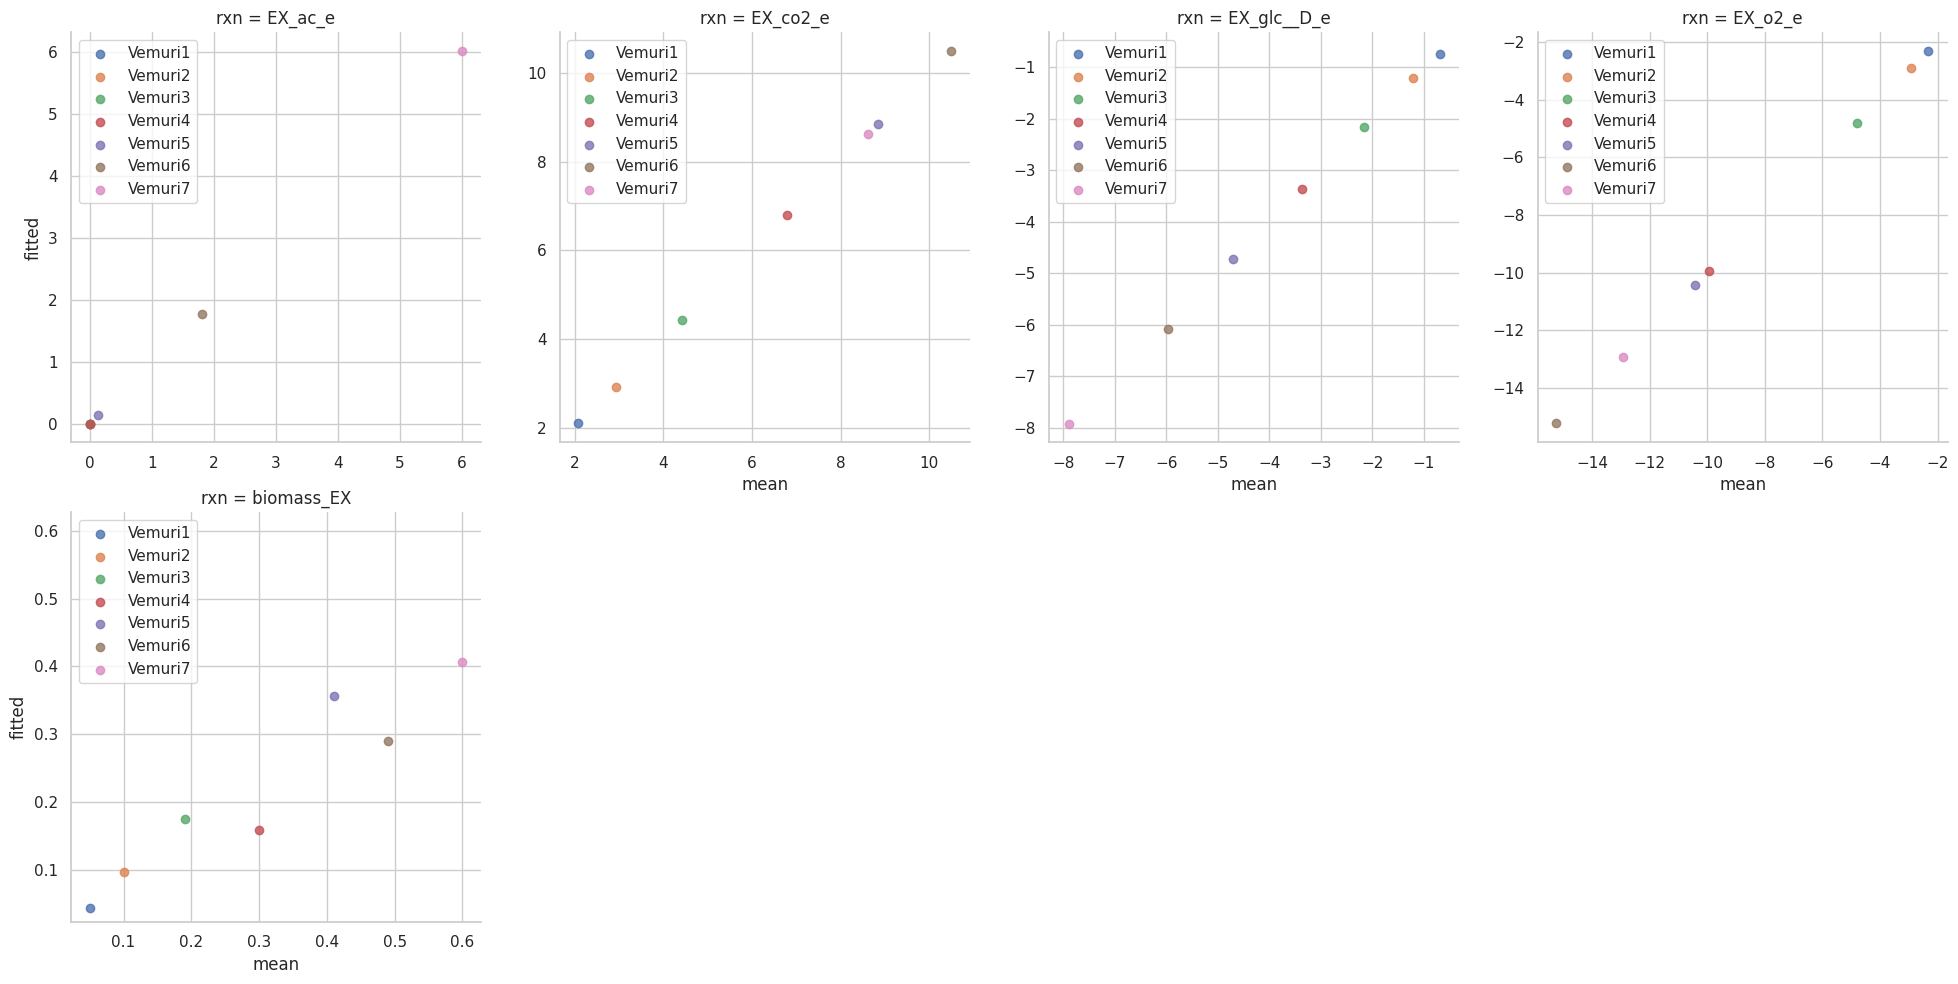

In [80]:
flux_reg, g = reg_flux_plot(tmodel, flux_data, conds)

<Axes: xlabel='growth_rate', ylabel='Gdiss'>

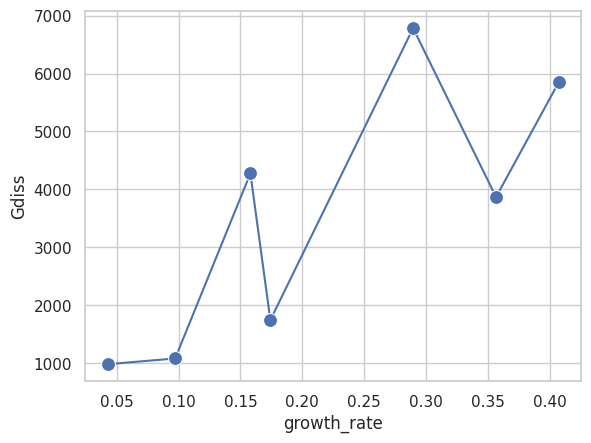

In [81]:
#calculate gdiss from exchange fluxes 
#for each condition sum Gdiss in sol 
sol = tmodel.solution()
sol = sol.loc[[rxn.id for rxn in tmodel.reactions if rxn in tmodel.boundary]]

#group gdiss by condition 
gdiss = sol.groupby('condition')['Gdiss'].sum()
gdiss =  pd.DataFrame(gdiss)

gdiss['growth_rate'] = sol.loc['biomass_EX'].set_index('condition')['v']
gdiss

# plot the gibbs energy dissipation 

#plot the gdiss against growth rate with joined dots
sns.lineplot(data=gdiss, x='growth_rate', y='Gdiss', marker='o', markersize=10)

In [82]:
qm_sol = tmodel.mvars['qm'].x

In [83]:
qm_sol

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00016667])

In [84]:
# for rxn in tmodel.reactions:
#     rxn.bounds = original_bounds[rxn.id]

NameError: name 'original_bounds' is not defined

In [85]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = 4900/tmodel.T.m, error_type = 'covariance')

#fix the values in the model 
tmodel.mvars['qm'].lb = qm_sol
tmodel.mvars['qm'].ub = qm_sol
tmodel.m.update() #update the model with the new bounds

#define a range of glucose uptake rate values to scan through 
GUR_range =  np.linspace(-1,-15, 15) 
print(GUR_range)

#set up a multiscenario optimization to scan over the glucose upake rate
thermo_flux.solver.gurobi.variable_scan(tmodel, GUR_range, var = tmodel.mvars['v'][0][tmodel.reactions.index(tmodel.reactions.EX_glc__D_e)]) # here we get the index for the glucose uptake reaction and use this to index the v variable in the gurobi model

tmodel.m.params.timeLimit = 120
tmodel.m.optimize()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[ -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13. -14.
 -15.]
Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 826 rows, 849 columns and 5290 nonzeros
Model fingerprint: 0x610c8b32
Model has 22 quadratic constraints
Model has 1 general constraint
Variable types: 750 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-04, 1e+06]
  RHS range        [3e-02, 1e+04]

Solving a multi-scenario model with 15 scenarios...

Presolve removed 453 rows and 522 columns
Presolve time: 0.01s
Presolved: 43

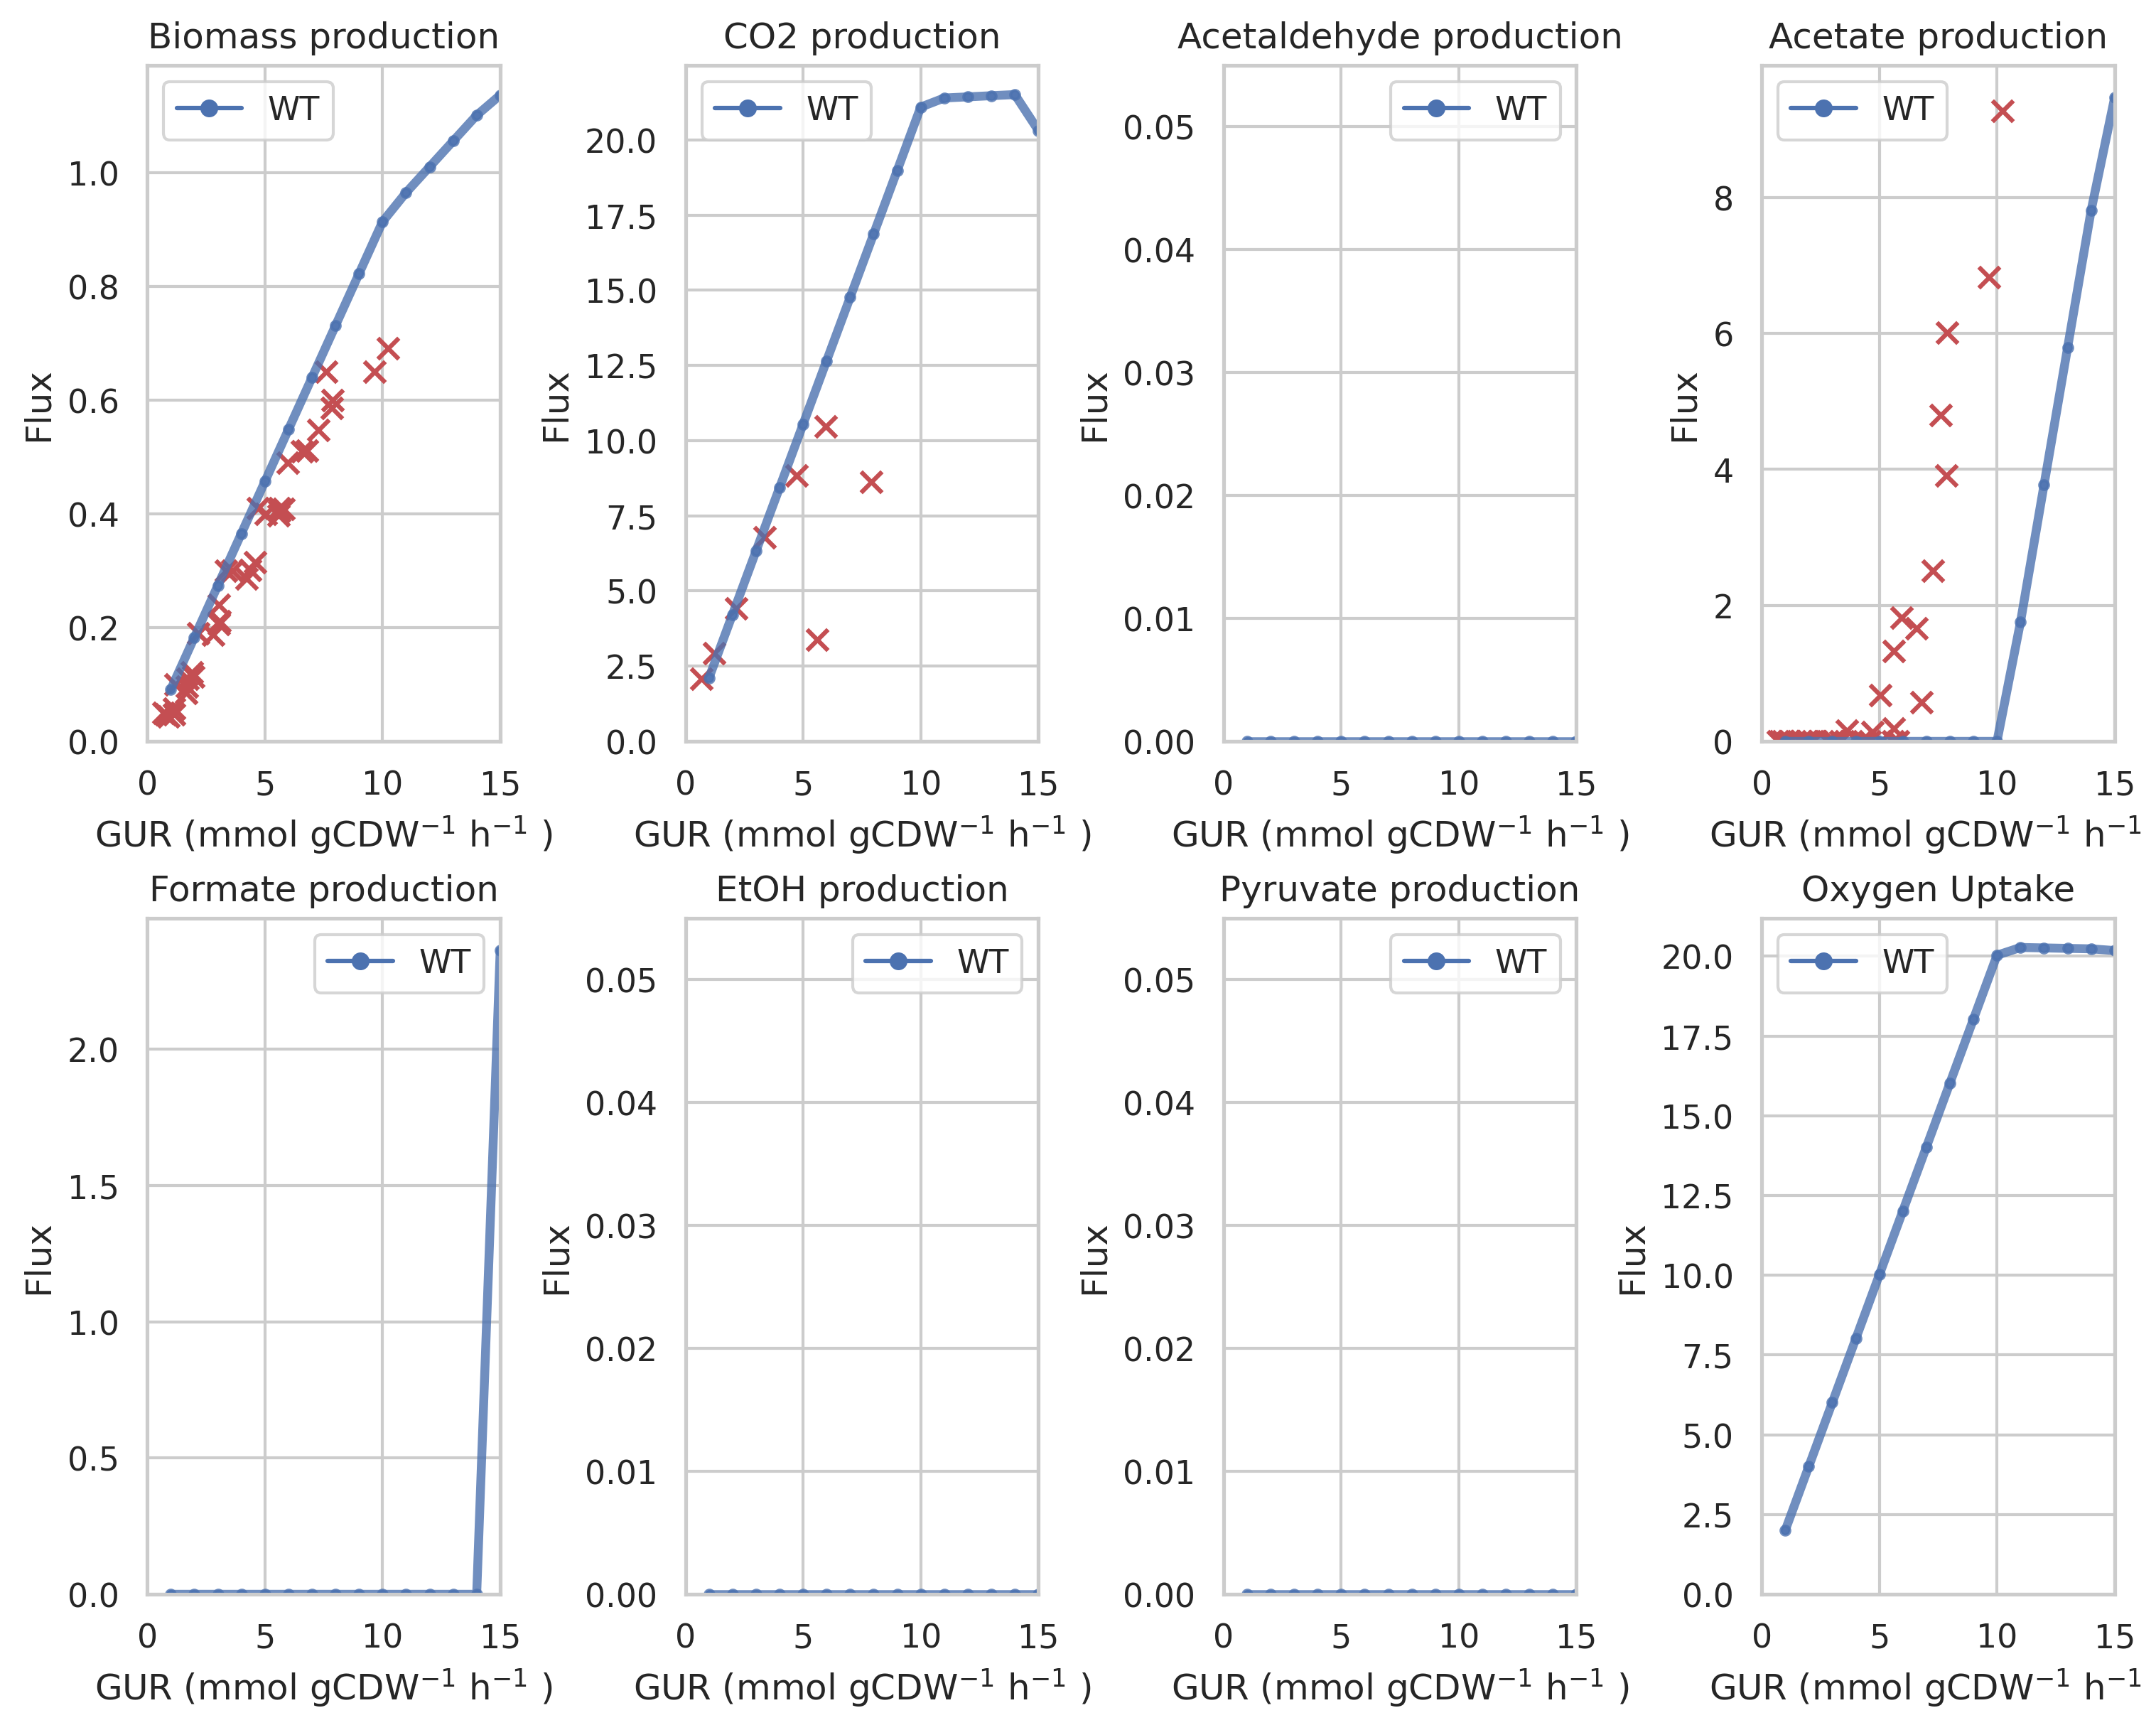

In [86]:
## make a new plot with all the data 
#get the fluxes from the multiscenario optimization
fluxes = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'v') 
fluxes= pd.DataFrame(fluxes[0].T, index = [rxn.id for rxn in tmodel.reactions])

fig = exchange_plot([fluxes])

rxn_list = ['biomass_EX', 'EX_co2_e', 'EX_acald_e','EX_ac_e','EX_for_e','EX_etoh_e','EX_pyr_e','EX_lac__D_e','O2_EX']
for i, ax in enumerate(fig.axes):

    #add the experimental data to the plot
    if rxn_list[i] in reg_all.columns.to_list():
        exp_data = reg_all[['EX_glc__D_e', rxn_list[i]]]
        

        ax.scatter(marker = 'x',s = 50, color='r' ,x=abs(reg_all['EX_glc__D_e']), y=abs(reg_all[rxn_list[i]]))





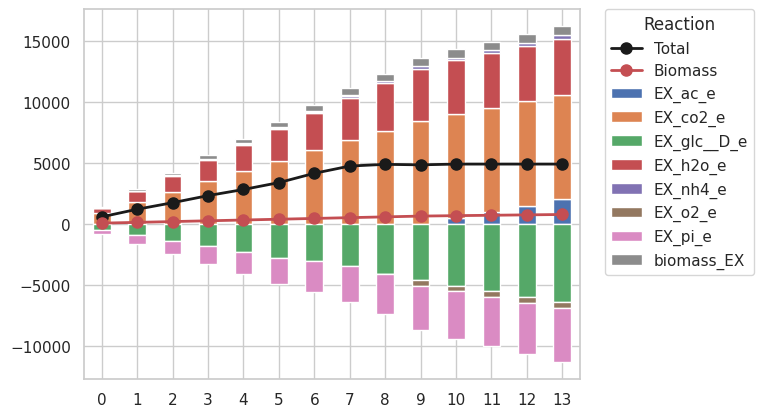

In [87]:
Gdiss = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'Gdiss') 
Gdiss= pd.DataFrame(Gdiss[0].T, index = [rxn.id for rxn in tmodel.boundary])

#drop column 14
Gdiss = Gdiss.drop(14, axis=1)

#round values to 5 dp
Gdiss = Gdiss.round(5)

#drop rows from gdiss with all zeros
Gdiss = Gdiss.loc[(Gdiss!=0).any(axis=1)]

#make a stacked bar graph for each condition in Gdiss (columns)
import matplotlib.pyplot as plt

# Create a stacked line graph
Gdiss.T.plot(kind='bar', stacked=True)

#overlay plot with sum of column
Gdiss.sum().plot(secondary_y=False, color='k', marker='o', linewidth=2, markersize=8, label='Total')

#overlay the biomass_EX Gdiss
Gdiss.loc['biomass_EX'].plot(secondary_y=False, color='r', marker='o', linewidth=2, markersize=8, label='Biomass')





#put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Reaction')

#


In [88]:
#show boundary reactions in the solution
sol = tmodel.solution()
sol = sol.loc[[rxn.id for rxn in tmodel.boundary]]
sol

,v,drG,Gdiss,drG0_prime,drG_error,drG_conc,b,condition
reaction,,,,,,,,
EX_ac_e,9.468398,260.516537,2466.674302,244.937774,0.0,15.578767,0.0,0
EX_acald_e,0.000000,-14.082163,-0.000000,-25.683401,0.0,11.601237,0.0,0
EX_akg_e,0.000000,658.722288,0.000000,628.610659,0.0,30.111628,0.0,0
EX_co2_e,20.311717,398.101237,8086.119579,386.000000,0.0,12.101237,0.0,0
EX_etoh_e,0.000000,-39.421633,-0.000000,-69.475993,0.0,30.054357,0.0,0
EX_for_e,2.361826,319.193617,753.879891,307.592377,0.0,11.601237,0.0,0
EX_fru_e,0.000000,458.970648,0.000000,418.366321,0.0,40.604328,0.0,0
EX_fum_e,0.000000,542.069867,0.000000,520.084836,0.0,21.985027,0.0,0
EX_glc__D_e,-15.000000,458.852458,-6882.786867,418.248133,0.0,40.604328,0.0,0


In [89]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = 4900/tmodel.T.m, error_type = 'covariance')

for i, rxn in enumerate(tmodel.reactions):
    if rxn.id in bounds_df.index:
       if (rxn.drG_SE.m) > 0: 
            tmodel.mvars['drG'][0][i].lb = round(bounds_df.loc[rxn.id]['lb'],8)
            tmodel.mvars['drG'][0][i].ub = round(bounds_df.loc[rxn.id]['ub'],8)
            #print(rxn.id, rxn.drG_SE, bounds_df2.loc[rxn.id]['lb'], bounds_df2.loc[rxn.id]['ub'])
tmodel.m.update()



#fix the values in the model 
tmodel.mvars['qm'].lb = qm_sol
tmodel.mvars['qm'].ub = qm_sol
tmodel.m.update() #update the model with the new bounds

#variabiliy analysis to idetify reversible reactions
thermo_flux.solver.gurobi.variability_analysis(tmodel, 'drG', condition_index = 0)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


NameError: name 'bounds_df' is not defined

In [ ]:
tmodel.m.optimize()

In [90]:

# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = 4900/tmodel.T.m, error_type = 'covariance')

#fix the values in the model 
tmodel.mvars['qm'].lb = qm_sol
tmodel.mvars['qm'].ub = qm_sol

tmodel.m.params.timeLimit = 120


thermo_flux.solver.gurobi.variability_analysis(tmodel, 'drG', condition_index = 0)


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 120


TypeError: variability_analysis() got an unexpected keyword argument 'condition_index'

In [ ]:
tmodel.m.optimize()

In [91]:
bounds2 = thermo_flux.solver.gurobi.variability_results(tmodel, 'drG', condition_index=0)

TypeError: variability_results() got an unexpected keyword argument 'condition_index'

In [92]:
#add reaction ids to bounds2

df = pd.DataFrame(bounds2).T
df.columns=['lb','ub']
df.index = [rxn.id for rxn in tmodel.reactions]

NameError: name 'bounds2' is not defined

In [93]:
df = df.loc[[rxn.id for rxn in tmodel.reactions if rxn not in tmodel.boundary]]
df = df.sort_values('lb')

df = df.drop('biomass_c', axis=0)

#identify ireversible reactions (where lb*ub < 0)
df['reversible'] = df['lb']*df['ub'] < 0
df['rxn'] = df.index

plt.figure(figsize=(10, 15))
plt.barh(df['rxn'], df['ub']-df['lb'], left=df['lb'])

#add a line at 0 
plt.axvline(x=0, color='black', linestyle='--')

#color bars if reversible False
for i, rev in enumerate(df['reversible']):
    if rev == False:
        plt.gca().get_children()[i].set_color('red')

plt.xlabel("drG0' (kJ/mol)")

NameError: name 'df' is not defined

In [94]:
tmodel.reactions.EX_glc__D_e.lower_bound = -10

In [95]:

# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = 4900/tmodel.T.m, error_type = 'covariance')

op_sol_fluxes = tmodel.optimize().fluxes

for i, var in enumerate(tmodel.mvars['v'][0]):
    var.lb = op_sol_fluxes.loc[tmodel.reactions[i].id]
    var.ub = op_sol_fluxes.loc[tmodel.reactions[i].id]

#fix the values in the model 
#tmodel.mvars['qm'].lb = qm_sol
#tmodel.mvars['qm'].ub = qm_sol

tmodel.m.params.timeLimit = 120


thermo_flux.solver.gurobi.variability_analysis(tmodel, 'ln_conc', condition_index = 0)


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 120


TypeError: variability_analysis() got an unexpected keyword argument 'condition_index'

In [96]:
tmodel.m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 826 rows, 849 columns and 5290 nonzeros
Model fingerprint: 0x951254bd
Model has 22 quadratic constraints
Model has 1 general constraint
Variable types: 750 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-01, 1e+06]
  RHS range        [3e-02, 1e+04]
Presolve removed 657 rows and 634 columns
Presolve time: 0.01s
Presolved: 170 rows, 269 columns, 3029 nonzeros
Presolved model has 54 quadratic constraint(s)
Variable types: 236 continuous, 33 integer (33 binary)

Root relaxation: objective 9.143518e-01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |

In [97]:
bounds3 = thermo_flux.solver.gurobi.variability_results(tmodel, 'ln_conc', condition_index=0)

TypeError: variability_results() got an unexpected keyword argument 'condition_index'

In [98]:
df = pd.DataFrame(bounds3).T
df.columns=['lb','ub']
df.index = [met.id for met in tmodel.metabolites]

df = df.sort_values('lb')

df = np.exp(df)*1000

#look up concentration bounds based on df index in model

df['original_lb'] = df.index.map(lambda x: tmodel.metabolites.get_by_id(x).lower_bound.m_as('mM'))
df['original_ub'] = df.index.map(lambda x: tmodel.metabolites.get_by_id(x).upper_bound.m_as('mM'))

NameError: name 'bounds3' is not defined

In [99]:


df['rxn'] = df.index

plt.figure(figsize=(10, 15))
plt.barh(df['rxn'], df['original_ub']-df['original_lb'], left=df['original_lb'], alpha = 0.5, color='grey')

plt.barh(df['rxn'], df['ub']-df['lb'], left=df['lb'])

#make log scale on x axis
plt.xscale('log')

#set x lim
plt.xlim([0,40])

plt.xlabel("Concentration' (mM)")

NameError: name 'df' is not defined

In [100]:



df['rxn'] = df.index

plt.figure(figsize=(10, 15))
plt.barh(df['rxn'], df['original_ub']-df['original_lb'], left=df['original_lb'], alpha = 0.5, color='grey')

plt.barh(df['rxn'], df['ub']-df['lb'], left=df['lb'])

#make log scale on x axis
plt.xscale('log')

#set x lim
plt.xlim([0,40])

plt.xlabel("Concentration' (mM)")

NameError: name 'df' is not defined